In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy.stats import gamma
from scipy.special import factorial, comb
import random
from copy import deepcopy
import tqdm

## Combinatorial problem formulations and QUBO funcs

###  Number partition problem 

Given a set $S$ of $N$ positive numbers 
$S = \{ n_{0}, \ldots , n_{N-1}\}$, is there a partition of $S$ into $P$ disjoint subsets $\{ R_0, \ldots , R_{P-1} \}$, such that the sum of values in 
each set is the same. I.e., can a set of $N$ assets with values $n_0, \ldots , n_{N-1}$ fairly be distributed between $P$ parties?

The Quadratic Unconstrained Binary Optimization model can be formulated in the following way

\begin{align}
	H = \sum_{p=0}^{P-1}  \left( \sum_{i=0}^{N-1} n_{i} x_{i, p} - \frac{1}{P} \sum_{i=0}^{N-1} n_{i} \right)^2 + M \sum_{i=0}^{N-1}  \left( 1- \sum_{p=0}^{P-1} x_{i, p} \right)^2 \, ,
\end{align}

and the decision variable $x_{i, p} \in \{0,1\}$ is defined as

\begin{align}
	x_{i, p} = 
    \begin{cases}
	1 & \text{if number } n_i \text{ of set } S \text{ is in set } R_p \\
	0 & \text{else}
    \end{cases} \, .
\end{align}

- $P=4$: Number of subsets.
- $N$: Number of values in set $S$.
- ${\rm{bits}} = N \cdot P$: Number of bits needed to represent problem QUBO.
- $M$: Penalty factor.

Expanding the Hamiltonians $H = H_o + M H_p$:


$$
H_o = P\alpha^2 + \sum_{i,p} (n_i^2 - 2\alpha n_i) x_{ip} + \sum_{p, i \ne i^{'}} n_i n_{i^{'}} x_{ip} x_{i^{'}p}
$$
where $\alpha = \sum_i n_i/P$.

$$
H_p = N - \sum_{i,p} x_{ip} + \sum_{i, p \ne p^{'}} x_{ip} x_{ip^{'}}
$$

### Traveling salesman problem

Given a graph $G=(V,E)$ with $N=|V|$ nodes (cities), what is the cheapest hamiltonian cycle, considering the edge $e_{i,j}$ as the cost from going from city $i$ to city $j$?

The Quadratic Unconstrained Binary Optimization model can be formulated in the following way

\begin{align}
	H = \sum_{t=1}^{N}   \sum_{i\ne j=1}^{N} e_{i,j} x_{t, i}x_{t+1, j}  + M \bigg[ \sum_{i=1}^{N}  \left( 1- \sum_{t=1}^{N} x_{t, i} \right)^2 + \sum_{t=1}^{N}  \left( 1- \sum_{i=1}^{N} x_{t, i} \right)^2  \bigg]\, ,
\end{align}

and the decision variable $\{x_{t, i}\}_{i,t=1,\dots,N} \in \{0,1\}^{N^2}$ is defined as

\begin{align}
	x_{t, i} = 
    \begin{cases}
	1 & \text{if city } i \text{ is visited at time step } t \\
	0 & \text{else}
    \end{cases} \, .
\end{align}

The constraint enforces the decision matrix $[x]_{t, i}$ to be a permutation matrix, ordering the temporal visit of each city.

- $N$: Number of cities/nodes.
- ${\rm{bits}} = N^2$: Number of bits needed to represent problem QUBO.
- $M$: Penalty factor.


Expanding the Hamiltonians $H = H_o + M H_p$:

$$
H_o = \sum_{t=1}^{N}   \sum_{i\ne j=1}^{N} e_{i,j} x_{t, i}x_{t+1, j}
$$

$$
H_p = 2N - 2\sum_{t,i}^{N} x_{ti} + \sum_{t,i}^{N} \biggl( \sum_{i^{'} \ne i}^{N} x_{ti} x_{ti^{'}} + \sum_{t^{'} \ne t}^{N} x_{ti} x_{t^{'}i} \biggr)
$$
where $N = N_{cities}$.

In [2]:
### QUBO functions

def L1_norm(Q, const):
    return const + np.sum(np.abs(Q))

def L1_norm_hot(Q, const, n_bits, temperature, max_prob_inf):
    return L1_norm(Q, const) + temperature*(n_bits*np.log(2) - np.log(max_prob_inf))

def build_numbs_set(N, P, seed):
    random.seed(seed)
    numbs = [int(1000*random.uniform(0.0, 1.0)) for _ in range(N)]
    total = sum(numbs)
    if numbs[-1] - (total % P) > 1:
        numbs[-1] -= (total % P)
    else:
        numbs[-1] += (P - (total % P))
    total = sum(numbs)
    return numbs

def idx_onehot(i, p, P):
    return i*P + p

def symmetrize(Q):
    return (Q + Q.T)/2

# NPP specific

def build_obj_NPP(numbs, N, P):
    H = np.zeros((N*P, N*P))
    alpha = np.sum(numbs)/P

    for p in range(P):
        for i in range(N):
            H[idx_onehot(i, p, P), idx_onehot(i, p, P)] = numbs[i]**2 - 2*alpha*numbs[i]
            for i_prime in range(N):
                if i_prime == i:
                    continue
                H[idx_onehot(i, p, P), idx_onehot(i_prime, p, P)] = numbs[i] * numbs[i_prime]
    const = P*alpha**2
    H = symmetrize(H)
    return H, const

def build_pen_NPP(N, P):
    H = np.zeros((N*P, N*P))
    for p in range(P):
        for i in range(N):
            H[idx_onehot(i, p, P), idx_onehot(i, p, P)] = -1
            for p_prime in range(P):
                if p_prime == p:
                    continue
                H[idx_onehot(i, p, P), idx_onehot(i, p_prime, P)] = 1
    const = N
    H = symmetrize(H)
    return H, const

def get_QUBO_NPP(N, P, M, seed, objective = True, penalization=True):
    # build a NPP QUBO with N integers, P partitions, M penalty factor, for problem identified with seed
    Q, const = np.zeros((N*P, N*P)), 0
    if objective:
        numbs = build_numbs_set(N, P, seed)
        Ho, const_o = build_obj_NPP(numbs, N, P)
        Q += Ho
        const += const_o
    if penalization:
        Hp, const_p = build_pen_NPP(N, P)
        Q += M*Hp
        const += M*const_p
    return Q, const

# TSP specific


def build_adjacency(Nc, seed, circle_flag):
    if circle_flag:
        # trivial construction of adj. matrix of graph with N cities on a circle. Modify this function to get more complex structures
        coordinates = [(1_000_000 * np.cos((index / Nc) * 2 * np.pi), 1_000_000 * np.sin((index / Nc) * 2 * np.pi)) for index in range(Nc)]
        distance_table = [[int(np.sqrt((coordinates[c_1][0] - coordinates[c_0][0]) ** 2 + (coordinates[c_1][1] - coordinates[c_0][1]) ** 2)) for c_0 in range(Nc)] for c_1 in range(Nc)]
    else:
        # random construction of the adjacency matrix, based on euclidian distance. (cities are uniformly randomly placed inside a square)
        np.random.seed(seed)
        coordinates = 1e6 * np.array( [np.random.uniform(low = -1, high = 1, size = 2) for i in range(Nc)] )
        distance_table = [[int(np.sqrt((coordinates[c_1][0] - coordinates[c_0][0]) ** 2 + (coordinates[c_1][1] - coordinates[c_0][1]) ** 2)) for c_0 in range(Nc)] for c_1 in range(Nc)]
    return np.array(distance_table)

def build_obj_TSP(distances, Nc):
    H = np.zeros((Nc**2, Nc**2))
    for t in range(Nc):
        for i in range(Nc):
            for i_prime in range(Nc):
                if i_prime != i:
                    H[idx_onehot(t, i, Nc), idx_onehot((t+1)%Nc, i_prime, Nc)] = distances[i, i_prime]
    H = symmetrize(H)
    const = 0
    return H, const

def build_pen_TSP(Nc):
    H = np.zeros((Nc**2, Nc**2))
    for t in range(Nc):
        for i in range(Nc):
            H[idx_onehot(t, i, Nc), idx_onehot(t, i, Nc)] = -2
            for i_prime in range(Nc):
                if i_prime != i:
                    H[idx_onehot(t, i, Nc), idx_onehot(t, i_prime, Nc)] += 1
            for t_prime in range(Nc):
                if t_prime != t:
                    H[idx_onehot(t, i, Nc), idx_onehot(t_prime, i, Nc)] += 1
    const = 2*Nc
    H = symmetrize(H)
    return H, const

def get_QUBO_TSP(Nc, M, seed, circle_flag = False, objective = True, penalization=True):
    # build a TSP QUBO with Nc cities, M penalty factor, for problem identified with seed
    Q, const = np.zeros((Nc**2, Nc**2)), 0
    if objective:
        distances = build_adjacency(Nc, seed, circle_flag)
        Ho, const_o = build_obj_TSP(distances, Nc)
        Q += Ho
        const += const_o
    if penalization:
        Hp, const_p = build_pen_TSP(Nc)
        Q += M*Hp
        const += M*const_p
    return Q, const


### Generally useful functions

def nearest_to(ref_array, element):
    """
    Given a requested element (e.g. energy), returns the nearest value in a reference array, together with its position in the array
    """
    diff = np.abs(ref_array - element)
    idx = np.where(diff == np.min(diff))[0][0]
    return idx, ref_array[idx]

def remove_outliers(l, whisker_len = 1.5):
    q1, q3 = np.percentile(l, [25, 75])
    thres = q3 + whisker_len*(q3-q1)
    l = np.delete(l, l > thres)
    return l, thres

## Random sampling and Gibbs sampling

In [3]:
### Random Sampling functions

def evaluate_energy(solution, Q, const):
    return const + np.dot(solution, np.dot(Q, solution))

def sample_sol(N, P):
    return np.random.randint(0, 2, size = N*P)

def RandomSampler(Q, const, N, P, n_sample):
    Es = np.ndarray((n_sample))
    for j in range(n_sample):
        x = sample_sol(N, P)
        Es[j] = evaluate_energy(x, Q, const)
    return Es

def SpectralDistribution(Q, const, n_bits):
    ener = np.array([ evaluate_energy(state_inttobin(i, n_bits), Q, const) for i in range(2**n_bits)])
    return ener

def RandomSampler_Feasible_NPP(N, P, seed, n_sample):
    numbs = np.array(build_numbs_set(N, P, seed))
    Es = np.ndarray((n_sample))
    for j in range(n_sample):
        assign = np.random.randint(P, size = N)
        subset_sums = [ np.sum(numbs[assign == p]) for p in range(P)]
        Es[j] = P*np.var(subset_sums) # NB the objective energy can be reformulated as the variance of the subsets' sums (scaled by P)
    return Es

def RandomSampler_Feasible_TSP(Nc, seed, n_sample, circle_flag):
    adj = build_adjacency(Nc, seed, circle_flag)
    Es = np.ndarray((n_sample))
    for j in range(n_sample):
        permu = np.random.permutation(np.arange(Nc))
        Es[j] = cost_permutation(permu, adj)
    return Es

def cost_permutation(perm, adj):
    Nc = len(perm)
    cost = 0
    for i in range(Nc):
        cost += adj[perm[i], perm[(i+1)%Nc]]
    return cost



#### Gibbs Sampling functions

def state_inttobin(i, n):
    state_string = bin(i)[2:].zfill(n)
    return [int(b) for b in state_string]

def state_bintoint(b):
    b_numb = ''.join([str(k) for k in b])
    return int(b_numb, 2)

def compute_Gibbs_probs(beta, Q, const):
    n, _ = np.shape(Q)
    ener = np.array([ evaluate_energy(state_inttobin(i, n), Q, const) for i in range(2**n)])
    probs = np.exp(-beta*ener)
    probs /= probs.sum()
    return probs, ener # NOTE: ener (same for probs) are ordered so that i-th entry is the energy of the i-th state, i.e. the number i in binary. 

def sample_Gibbs(probs, eners, n_samples):
    eners_sampled = np.random.choice(eners, p = probs, size = n_samples)
    return eners_sampled

def perf_GibbsSampler(beta, Q, const, n_G_samples):
    probs, ener = compute_Gibbs_probs(beta, Q, const)
    return sample_Gibbs(probs, ener, n_G_samples)

N = 10, P = 2
Dim_RS: 18.44 +- 0.5 		beta_RS: 4.5e-06 +- 1.3e-07


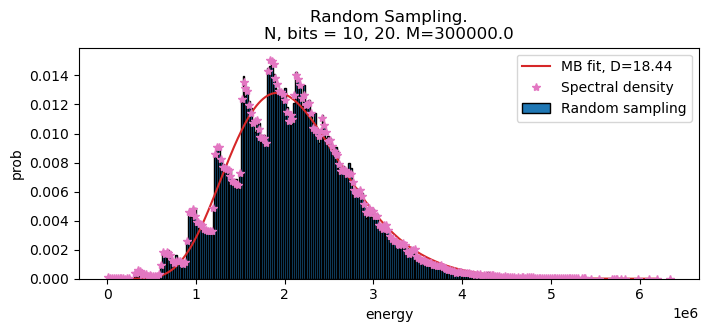

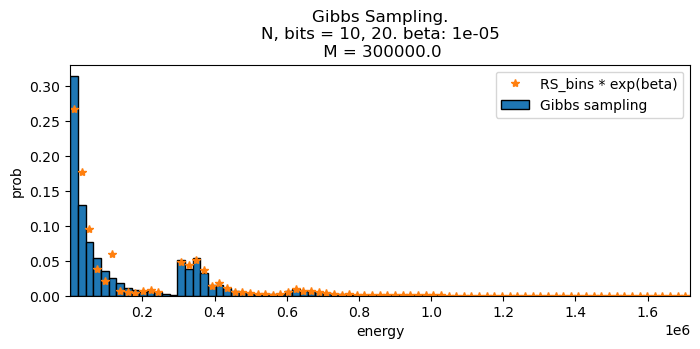

In [4]:
N, P = 10, 2
n_bits = N*P
print(f"N = {N}, P = {P}")
vseed = 45
M = 3e5
Q, const = get_QUBO_NPP(N, P, M, vseed)

# Start sampling data
n_RS_sample = 100_000
n_GS_sample = n_RS_sample
# create RS and Gibbs data
Es_RS = RandomSampler(Q, const, N, P, n_RS_sample)
Es_SD = SpectralDistribution(Q, const, n_bits)
beta = 1e-5 # 2e-5
Es_GS = perf_GibbsSampler(beta, Q, const, n_GS_sample)


def combine_SD(Es_SD, bin_width_RS, range):
    bins = int((range[1] - range[0])/bin_width_RS)
    counts, _ = np.histogram(Es_SD.flatten(), range = range, bins = bins)
    density_SD = counts / counts.sum() # normalize to get a probability
    return density_SD



### Random sampling
# get histogram data
bins = 300
fit_lim = None
counts, x_bins = np.histogram(Es_RS.flatten(), bins = bins)
density_RS = counts / counts.sum() # normalize to get a probability
x_pos_RS = (x_bins[1:] + x_bins[:-1])/2
bin_width_RS = x_bins[1]-x_bins[0]
mask = density_RS > 0 # filter out empty bins
density_RS, x_pos_RS = density_RS[mask], x_pos_RS[mask]
# plot RS
fig = plt.figure(figsize=(8, 3))
ax = fig.add_subplot(111)
ax.bar(x_pos_RS, density_RS, width = bin_width_RS, edgecolor='k', linewidth=1, label ="Random sampling")
ax.set_ylabel("prob")
ax.set_xlabel("energy")
plt.title(f"Random Sampling.\nN, bits = {N}, {N*P}. M={M}")
# fit
if fit_lim == None:
    start, end = 0, -2
else:
    start, _ = nearest_to(x_pos_RS, fit_lim[0])
    end, _ = nearest_to(x_pos_RS, fit_lim[1])
XS = np.linspace(x_pos_RS[start], x_pos_RS[end], 1000)
f = lambda x, D, beta, normal : gamma.pdf(x, (D+1)/2, loc = 0, scale = 1/beta) * bin_width_RS * normal
coef_RS, coef_var = sp.optimize.curve_fit(f, x_pos_RS[start:end+1], density_RS[start:end+1], p0 = [5, 1e-7, 1])
coef_std = np.sqrt(np.diag(coef_var))
ax.plot(XS, f(XS, *coef_RS), color = "C3", label = f"MB fit, D={np.round(coef_RS[0], 2)}")
print(f"Dim_RS: {np.round(coef_RS[0], 2)} +- {np.round(coef_std[0], 2)} \t\tbeta_RS: {np.format_float_scientific(coef_RS[1], 1)} +- {np.format_float_scientific(coef_std[1], 1)}")
# plot SpectralDistribution on top of it
density_SD = combine_SD(Es_SD, bin_width_RS, range = (x_bins[0], x_bins[-1]+1))
ax.plot(x_pos_RS, density_SD[mask], "*", color = "C6", label = f"Spectral density")
ax.legend(fontsize = 10, loc='best')
plt.show()






### Gibbs sampling
# get histogram data
bins = int(bins * (np.max(Es_GS) - np.min(Es_GS))/(np.max(Es_RS) - np.min(Es_RS))) # in order to have same bin sizes wrt RS plot 
fit_lim = None
counts, x_bins = np.histogram(Es_GS.flatten(), bins = bins)
density = counts / counts.sum() # normalize to get a probability
x_pos = (x_bins[1:] + x_bins[:-1])/2
bin_width_GS = x_bins[1]-x_bins[0]
mask = density > 0 # filter out empty bins
density, x_pos = density[mask], x_pos[mask]
# plot GS
fig = plt.figure(figsize=(8, 3))
ax = fig.add_subplot(111)
ax.bar(x_pos, density, width = bin_width_GS, edgecolor='k', linewidth=1, label ="Gibbs sampling")
ax.set_ylabel("prob")
ax.set_xlabel("energy")
plt.title(f"Gibbs Sampling.\nN, bits = {N}, {N*P}. beta: {beta}\n M = {M}")
# plot RandomSampling-GibbsEnhanced on top of it
density_RS_enhanced = density_RS * np.exp(-beta*x_pos_RS)
density_RS_enhanced /= np.sum(density_RS_enhanced)
ax.plot(x_pos_RS, density_RS_enhanced, "*", color = "C1", label = f"RS_bins * exp(beta)")
ax.legend(fontsize = 10, loc='best')
ax.set_xlim(np.min(Es_GS), np.max(Es_GS))
plt.show()

## M technique for Gibbs sampling

Implement method to choose penalty factor $M$.
Assumptions:
- Sampling is according to Gibbs factor (perfect Gibbs sampling). Generally, it differs from annealing sampling, since it doesn't suffer from local minima traps.
- A post-processing bit-swap local search is performed (this assumption may be dropped, but the math of the final formulation may get more involved). So it's actually perfect Gibbs followed by bit-swap.
- Estimation of the number of feasible solutions is given. Also, the number of infeasible solutions violating the constraints by $k = 1,2,\dots, k_{max}$ (e.g. $k_{max} = 4$) is given. In other words, the first infeasibilty peaks of $H_{pen}$ have been identified, either analytically or numerically.

TODO: show and explain final formula of the method

In [5]:
# Gibbs sampling with bit-swap

def state_inttobin(i, n):
    state_string = bin(i)[2:].zfill(n)
    return [int(b) for b in state_string]

def state_bintoint(b):
    b_numb = ''.join([str(k) for k in b])
    return int(b_numb, 2)

def perf_GibbsSampler_bitswap(beta, Q, const, nbits, n_samples):
    probs, ener = compute_Gibbs_probs(beta, Q, const)
    return sample_Gibbs_bitswap(probs, ener, n_samples, nbits)

def sample_Gibbs_bitswap(probs, eners, n_samples, nbits):
    states_sampled_int = np.random.choice(np.arange(2**(nbits)), p = probs, size = n_samples)
    for i in range(n_samples):
        states_sampled_int[i] = bitswap(states_sampled_int[i], eners, nbits)
    states_sampled_bin = [state_inttobin(x, nbits) for x in states_sampled_int]
    return eners[states_sampled_int], states_sampled_bin

def bitswap(state_int, eners, nbits):
    '''Performs bit-swap search: for all hamming distance 1 neighbours of the given state, returns the best one in terms of energy'''
    neighs_int = neighbours(state_int, nbits)
    eners_neigh = eners[neighs_int]
    if np.min(eners_neigh) < eners[state_int]:
        return neighs_int[ np.where(eners_neigh == np.min(eners_neigh))[0][0] ]
    return state_int

def neighbours(state_int, nbits):
    state_bin = state_inttobin(state_int, nbits)
    neighs_int = np.ndarray((nbits), dtype = int)
    for i in range(nbits):
        neigh_bin = deepcopy(state_bin)
        neigh_bin[i] = 1 - neigh_bin[i]
        neighs_int[i] = state_bintoint(neigh_bin)
    return neighs_int


# Gibbs sampling

def perf_GibbsSampler(beta, Q, const, nbits, n_samples):
    probs, ener = compute_Gibbs_probs(beta, Q, const)
    return sample_Gibbs(probs, ener, n_samples, nbits)

def sample_Gibbs(probs, eners, n_samples, nbits):
    states_sampled_int = np.random.choice(np.arange(2**(nbits)), p = probs, size = n_samples)
    eners_sampled = eners[states_sampled_int]
    states_sampled_bin = [state_inttobin(x, nbits) for x in states_sampled_int]
    return eners_sampled, states_sampled_bin


#### post-check

def count_feasibility_optimality(states, Q_pen, const_pen, Es, E_f):
    cnt_feas,cnt_opt = 0, 0
    for i_state, state in enumerate(states):
        if np.isclose(evaluate_energy(state, Q_pen, const_pen), 0):
            cnt_feas += 1
            if Es[i_state] <= E_f:
                cnt_opt += 1
    return cnt_feas/len(states), cnt_opt/len(states)

In [63]:
########## TO BE DELETED after showing the group the change in the tail


import numpy as np
from scipy.special import factorial, comb
import random



### Main function


def M_method_feas(size, problem_type, info_instance, info_type, beta, peak_max, min_pfeas, E_LB = 0, circle_flag = False):
    ## evaluate violation peaks and cumulatives
    match problem_type:
        case "NPP":
            N, P = size
            p_viols = p_viols_exact_NPP(N, P, peak_max)
        case "TSP":
            Nc = size
            p_viols = p_viols_exact_TSP(Nc, peak_max)

    #cumul_exp, cumul_tail = cumulatives_exp_unique(E_f, beta, size, info_instance, info_type, problem_type, circle_flag = circle_flag)
    cumul_exp_feas = cumulative_exp_integral_feas(beta, size, info_instance, info_type, problem_type, E_LB, circle_flag = circle_flag)
    
    ## Ensure poly is correctly built
    # check if poly(1)>0
    min_pfeas_triviality = f_min_pfeas_triviality_feas(p_viols[0], p_viols[1:], cumul_exp_feas, beta, E_LB)
    if min_pfeas <= min_pfeas_triviality:
        print(f"With tolerance {min_pfeas}, the sampling probability requirement is satisfied for any M. Setting M=0.")
        return 0
    
    ## build and solve poly
    p_feas_term = -(1/min_pfeas - 1) * cumul_exp_feas
    def func_M(M):
        ''' Implements g function.  g(beta, M) =  \sum_v [ exp(-beta*(E_LB + Mv)) * p_pen(v) ]  +  p_pen(0)*[ exp(-beta*E_f)*(1 - cumul(E_f)) - (1-eta)/eta * cumul_exp_Ef ] '''
        M = np.float128(M)
        exp_vec = np.array([ np.exp(-beta*(E_LB + M*j)) for j in np.arange(1, len(p_viols)) ], dtype = np.float128)
        return np.dot(exp_vec.flatten(), p_viols[1:]) + np.float128(p_feas_term)*p_viols[0]

    x0 = 1
    M = my_root_finder(func_M, x0)
    print(f"For this instance, sampling temperature = {np.format_float_scientific(1/beta, 3)} and required feasible probability in at least {np.round(min_pfeas, 3)}, the chosen M is {np.format_float_scientific(M, 2)} (last violation peak used is {peak_max})")
    
    return M, min_pfeas


def cumulative_exp_integral_feas(beta, size,  info_instance, info_type, problem_type, E_LB = 0, n_chunks = 10_000, n_samples = 10_000, circle_flag = False):
    ''' Computes the exponential-cumulative until E_f (ie approximates the Gibbs integral) and the tail (ie 1 - cumulative)'''
    match problem_type:
        case "NPP":
            N, P = size
            match info_type: 
                case "numbers":
                    eners = RandomSampler_Feasible_NPP_wnumbers(N, P, np.array(info_instance), n_samples)
                case "seed":
                    eners = RandomSampler_Feasible_NPP_wseed(N, P, info_instance, n_samples)
                case _:
                    raise ValueError(f"Info type {info_type} is not amomg the implemented ones")
        case "TSP":
            Nc = size
            match info_type: 
                case "adjacency":
                    eners = RandomSampler_Feasible_TSP_wadjacency(Nc, info_instance, n_samples)
                case "seed":
                    eners = RandomSampler_Feasible_TSP_wseed(Nc, info_instance, n_samples, circle_flag)
                case _:
                    raise ValueError(f"Info type {info_type} is not amomg the implemented ones")
        case _:
            raise ValueError(f"Problem type {problem_type} is not amomg the implemented ones")
            
    delta = (np.max(eners) - E_LB) / n_chunks
    cumul_exp_feas = np.sum([ np.exp(- np.float128(beta) * (E_LB + (j+1)*delta) ) * np.sum( np.logical_and(eners > E_LB + j*delta, eners <= E_LB + (j+1)*delta) ) / len(eners) for j in np.arange(n_chunks) ])
    return cumul_exp_feas


def f_min_pfeas_triviality_feas(p_feas, p_violations, cumul_exp_feas, beta, E_LB):
    ''' Lower bound of eta for poly root existence. Below this, no solution -> any M is good'''
    return cumul_exp_feas / (cumul_exp_feas + np.exp(-beta*E_LB)*np.sum(p_violations)/p_feas)


def M_method_opt(size, problem_type, info_instance, info_type, beta, peak_max, min_pfeas, E_f, E_LB = 0, circle_flag = False):
    ## evaluate violation peaks and cumulatives
    match problem_type:
        case "NPP":
            N, P = size
            p_viols = p_viols_exact_NPP(N, P, peak_max)
        case "TSP":
            Nc = size
            p_viols = p_viols_exact_TSP(Nc, peak_max)

    #cumul_exp, cumul_tail = cumulatives_exp_unique(E_f, beta, size, info_instance, info_type, problem_type, circle_flag = circle_flag)
    cumul_exp_good, cumul_exp_tail_loose, cumul_exp_tail_new = cumulatives_exp_integral(E_f, beta, size, info_instance, info_type, problem_type, E_LB, circle_flag = circle_flag, n_chunks=10_000)
    
    ## Ensure poly is correctly built
    # check if poly(1)>0
    min_pfeas_triviality = f_min_pfeas_triviality(p_viols[0], p_viols[1:], cumul_exp_good, cumul_exp_tail_new, beta, E_LB)
    if min_pfeas <= min_pfeas_triviality:
        print(f"With tolerance {min_pfeas}, the sampling probability requirement is satisfied for any M. Setting M=0.")
        return 0
    # ensures poly(0)<0 and thus solution existence (decrease desidered probability if it is unattainable)
    max_pfeas_existence = f_min_pfeas_existence(cumul_exp_good, cumul_exp_tail_new)
    if min_pfeas >= max_pfeas_existence:
        epsilon = 1e-2
        if np.isclose(max_pfeas_existence, 0):
            raise ValueError(f"Maximum eta possible is too small, evaluates to {max_pfeas_existence}.\nYou should increase E_f to allow more random samples in [E_LB, E_f] to evaluate the integral. Atm E_LB = {E_LB} and E_f = {E_f}")
        print(f"With tolerance {min_pfeas}, poly root doesn't exist. Feasibility tolerance decreased to {max_pfeas_existence - epsilon}")
        min_pfeas = max_pfeas_existence - epsilon
    
    ## build and solve poly
    p_feas_term = -(1/min_pfeas - 1) * cumul_exp_good  +  cumul_exp_tail_new    

    # poly_alpha = lambda alpha:  p_feas_term*p_viols[0] + np.sum([ np.exp(-beta*E_LB)* p_violation * alpha**(j+1) for j, p_violation in enumerate(p_viols[1:])])
    # print(f"Poly_a(1) = {poly_alpha(1)}\tPoly_a(0) = {poly_alpha(0)}")
    # alpha_star = sp.optimize.brentq(poly_alpha, a = 0, b = 1)
    # M = -np.log(alpha_star)/beta
    def func_M(M):
        ''' Implements g function.  g(beta, M) =  \sum_v [ exp(-beta*(E_LB + Mv)) * p_pen(v) ]  +  p_pen(0)*[ exp(-beta*E_f)*(1 - cumul(E_f)) - (1-eta)/eta * cumul_exp_Ef ] '''
        M = np.float128(M)
        exp_vec = np.array([ np.exp(-beta*(E_LB + M*j)) for j in np.arange(1, len(p_viols)) ], dtype = np.float128)
        return np.dot(exp_vec.flatten(), p_viols[1:]) + np.float128(p_feas_term)*p_viols[0]
    #print(f"Func_M(0) = {func_M(0)!s}\tFunc_M(1e9) = {func_M(1e9)!s}")
    x0 = np.max((1, E_f))
    M = my_root_finder(func_M, x0)
    #result = sp.optimize.root(func_M, x0 = 0)  # scipy root finder. However, float128 are not usable inside it
    #M = result.x[0]
    print(f"For this instance, sampling temperature = {np.format_float_scientific(1/beta, 3)} and required probability in [0, E_f = {E_f}] at least {np.round(min_pfeas, 3)}, the chosen M is {np.format_float_scientific(M, 2)} (last violation peak used is {peak_max})")
    
    return M, min_pfeas


def M_method_badtail(size, problem_type, info_instance, info_type, beta, peak_max, min_pfeas, E_f, E_LB = 0, circle_flag = False):
    ## evaluate violation peaks and cumulatives
    match problem_type:
        case "NPP":
            N, P = size
            p_viols = p_viols_exact_NPP(N, P, peak_max)
        case "TSP":
            Nc = size
            p_viols = p_viols_exact_TSP(Nc, peak_max)

    #cumul_exp, cumul_tail = cumulatives_exp_unique(E_f, beta, size, info_instance, info_type, problem_type, circle_flag = circle_flag)
    cumul_exp_good, cumul_exp_tail, cumul_exp_tail_new = cumulatives_exp_integral(E_f, beta, size, info_instance, info_type, problem_type, E_LB, circle_flag = circle_flag, n_chunks = 10_000)
    
    ## Ensure poly is correctly built
    # check if poly(1)>0
    min_pfeas_triviality = f_min_pfeas_triviality(p_viols[0], p_viols[1:], cumul_exp_good, cumul_exp_tail, beta, E_LB)
    if min_pfeas <= min_pfeas_triviality:
        print(f"With tolerance {min_pfeas}, the sampling probability requirement is satisfied for any M. Setting M=0.")
        return 0
    # ensures poly(0)<0 and thus solution existence (decrease desidered probability if it is unattainable)
    max_pfeas_existence = f_min_pfeas_existence(cumul_exp_good, cumul_exp_tail)
    if min_pfeas >= max_pfeas_existence:
        epsilon = 1e-2
        if np.isclose(max_pfeas_existence, 0):
            raise ValueError(f"Maximum eta possible is too small, evaluates to {max_pfeas_existence}.\nYou should increase E_f to allow more random samples in [E_LB, E_f] to evaluate the integral. Atm E_LB = {E_LB} and E_f = {E_f}")
        print(f"With tolerance {min_pfeas}, poly root doesn't exist. Feasibility tolerance decreased to {max_pfeas_existence - epsilon}")
        min_pfeas = max_pfeas_existence - epsilon
    
    ## build and solve poly
    p_feas_term = -(1/min_pfeas - 1) * cumul_exp_good  +  cumul_exp_tail
    
    # poly_alpha = lambda alpha:  p_feas_term*p_viols[0] + np.sum([ np.exp(-beta*E_LB)* p_violation * alpha**(j+1) for j, p_violation in enumerate(p_viols[1:])])
    # print(f"Poly_a(1) = {poly_alpha(1)}\tPoly_a(0) = {poly_alpha(0)}")
    # alpha_star = sp.optimize.brentq(poly_alpha, a = 0, b = 1)
    # M = -np.log(alpha_star)/beta
    def func_M(M):
        ''' Implements g function.  g(beta, M) =  \sum_v [ exp(-beta*(E_LB + Mv)) * p_pen(v) ]  +  p_pen(0)*[ exp(-beta*E_f)*(1 - cumul(E_f)) - (1-eta)/eta * cumul_exp_Ef ] '''
        M = np.float128(M)
        exp_vec = np.array([ np.exp(-beta*(E_LB + M*j)) for j in np.arange(1, len(p_viols)) ], dtype = np.float128)
        return np.dot(exp_vec.flatten(), p_viols[1:]) + np.float128(p_feas_term)*p_viols[0]
    #print(f"Func_M(0) = {func_M(0)!s}\tFunc_M(1e9) = {func_M(1e9)!s}")
    x0 = np.max((1, E_f))
    M = my_root_finder(func_M, x0)
    #result = sp.optimize.root(func_M, x0 = 0)  # scipy root finder. However, float128 are not usable inside it
    #M = result.x[0]
    print(f"For this instance, sampling temperature = {np.format_float_scientific(1/beta, 3)} and required probability in [0, E_f = {E_f}] at least {np.round(min_pfeas, 3)}, the chosen M is {np.format_float_scientific(M, 2)} (last violation peak used is {peak_max})")
    
    return M, min_pfeas


### Random feasible Sampler functions


def RandomSampler_Feasible_NPP_wseed(N, P, seed, n_sample):
    numbs = np.array(build_numbs_set(N, P, seed))
    Es = np.ndarray((n_sample))
    for j in range(n_sample):
        assign = np.random.randint(P, size = N)
        subset_sums = [ np.sum(numbs[assign == p]) for p in range(P)]
        Es[j] = P*np.var(subset_sums) # NB the objective energy can be reformulated as the variance of the subsets' sums (scaled by P)
    return Es

def build_numbs_set(N, P, seed):
    random.seed(seed)
    numbs = [int(1000*random.uniform(0.0, 1.0)) for _ in range(N)]
    total = sum(numbs)
    if numbs[-1] - (total % P) > 1:
        numbs[-1] -= (total % P)
    else:
        numbs[-1] += (P - (total % P))
    total = sum(numbs)
    return numbs

def RandomSampler_Feasible_NPP_wnumbers(N, P, numbs, n_sample):
    Es = np.ndarray((n_sample))
    for j in range(n_sample):
        assign = np.random.randint(P, size = N)
        subset_sums = [ np.sum(numbs[assign == p]) for p in range(P)]
        Es[j] = P*np.var(subset_sums) # NB the objective energy can be reformulated as the variance of the subsets' sums (scaled by P)
    return Es


def RandomSampler_Feasible_TSP_wseed(Nc, seed, n_sample, circle_flag):
    adj = build_adjacency(Nc, seed, circle_flag)
    Es = np.ndarray((n_sample))
    for j in range(n_sample):
        permu = np.random.permutation(np.arange(Nc))
        Es[j] = cost_permutation(permu, adj)
    return Es

def build_adjacency(Nc, seed, circle_flag):
    if circle_flag:
        # trivial construction of adj. matrix of graph with N cities on a circle. Modify this function to get more complex structures
        coordinates = [(1_000_000 * np.cos((index / Nc) * 2 * np.pi), 1_000_000 * np.sin((index / Nc) * 2 * np.pi)) for index in range(Nc)]
        distance_table = [[int(np.sqrt((coordinates[c_1][0] - coordinates[c_0][0]) ** 2 + (coordinates[c_1][1] - coordinates[c_0][1]) ** 2)) for c_0 in range(Nc)] for c_1 in range(Nc)]
    else:
        # random construction of the adjacency matrix, based on euclidian distance. (cities are uniformly randomly placed inside a square)
        np.random.seed(seed)
        coordinates = 1e6 * np.array( [np.random.uniform(low = -1, high = 1, size = 2) for i in range(Nc)] )
        distance_table = [[int(np.sqrt((coordinates[c_1][0] - coordinates[c_0][0]) ** 2 + (coordinates[c_1][1] - coordinates[c_0][1]) ** 2)) for c_0 in range(Nc)] for c_1 in range(Nc)]
    return np.array(distance_table)

def cost_permutation(perm, adj):
    Nc = len(perm)
    cost = 0
    for i in range(Nc):
        cost += adj[perm[i], perm[(i+1)%Nc]]
    return cost

def RandomSampler_Feasible_TSP_wadjacency(Nc, adj, n_sample):
    Es = np.ndarray((n_sample))
    for j in range(n_sample):
        permu = np.random.permutation(np.arange(Nc))
        Es[j] = cost_permutation(permu, adj)
    return Es


### Auxiliary functions

def my_root_finder(f, x0):
    ''' Forces usage of np.longdouble to find root of (monotonically decreasing (f)'''
    x = np.float128(x0)
    tol = 1

    # find interval (multiply by 10)
    n_iter = 0
    if f(x) < 0:
        interval = [0, x]
    else:
        while f(x) > 0:
            n_iter += 1
            x_old = x
            x = 10*x
            if n_iter == 100:
                raise ValueError("Iteration 100 of first bisection algorithm part reached (finding the interval)")
        interval = [x_old, x]

    # pinpoint root (divide by 2)
    while interval[1] - interval[0] > tol:
        n_iter += 1
        midpoint = (interval[1] + interval[0])/2
        if f(midpoint) > 0:
            interval = [midpoint, interval[1]]
        else:
            interval = [interval[0], midpoint]
    root = (interval[1] + interval[0])/2

    #print(f"n_iters of my_root_finder = {n_iter1}")
    return root


def cumulatives_exp_integral(E_f, beta, size,  info_instance, info_type, problem_type, E_LB = 0, n_chunks = 10_000, n_samples = 10_000, circle_flag = False):
    ''' Computes the exponential-cumulative until E_f (ie approximates the Gibbs integral) and the tail (ie 1 - cumulative)'''
    match problem_type:
        case "NPP":
            N, P = size
            match info_type: 
                case "numbers":
                    eners = RandomSampler_Feasible_NPP_wnumbers(N, P, np.array(info_instance), n_samples)
                case "seed":
                    eners = RandomSampler_Feasible_NPP_wseed(N, P, info_instance, n_samples)
                case _:
                    raise ValueError(f"Info type {info_type} is not amomg the implemented ones")
        case "TSP":
            Nc = size
            match info_type: 
                case "adjacency":
                    eners = RandomSampler_Feasible_TSP_wadjacency(Nc, info_instance, n_samples)
                case "seed":
                    eners = RandomSampler_Feasible_TSP_wseed(Nc, info_instance, n_samples, circle_flag)
                case _:
                    raise ValueError(f"Info type {info_type} is not amomg the implemented ones")
        case _:
            raise ValueError(f"Problem type {problem_type} is not amomg the implemented ones")
            
    delta = (E_f - E_LB) / n_chunks
    cumul_exp_good = np.sum([ np.exp(- np.float128(beta) * (E_LB + (j+1)*delta) ) * np.sum( np.logical_and(eners > E_LB + j*delta, eners <= E_LB + (j+1)*delta) ) / len(eners) for j in np.arange(n_chunks) ])
    cumul_exp_tail = np.sum(eners > E_f)/len(eners) * np.exp(-beta*E_f)
    delta = (np.max(eners) - E_f) / n_chunks
    cumul_exp_tail_integral = np.sum([ np.exp(- np.float128(beta) * (E_f + j*delta) ) * np.sum( np.logical_and(eners > E_f + j*delta, eners <= E_f + (j+1)*delta) ) / len(eners) for j in np.arange(n_chunks) ])

    return cumul_exp_good, cumul_exp_tail, cumul_exp_tail_integral

# def cumulatives_exp_unique(E_f, beta, size, seed, problem_type, n_samples = 10_000, circle_flag = False):
#     ''' Computes the feasible cumulative at E_f, multiplied by the exponential (loose approximation fo the Gibbs integral) and the tail (ie 1 - cumulative)'''
#     raise NotImplementedError
#     if problem_type == "NPP":
#         N, P = size
#         eners = RandomSampler_Feasible_NPP(N, P, seed, n_samples)
#     elif problem_type == "TSP":
#         Nc = size
#         eners = RandomSampler_Feasible_TSP(Nc, seed, n_samples, circle_flag)

#     crude_cumul = np.sum(eners <= E_f)/len(eners)
#     if crude_cumul == 0:
#         print("Empirical sampling cumulative at E_f evaluates to 0")
#     cumul_tail = np.sum(eners > E_f)/len(eners)
#     return crude_cumul*np.exp(-beta*E_f), cumul_tail


def f_min_pfeas_triviality(p_feas, p_violations, cumul_exp_good, cumul_exp_tail, beta, E_LB):
    ''' Lower bound of eta for poly root existence. Below this, no solution -> any M is good'''
    return cumul_exp_good / (cumul_exp_good + cumul_exp_tail + np.exp(-beta*E_LB)*np.sum(p_violations)/p_feas)

def f_min_pfeas_existence(cumul_exp_good, cumul_exp_tail):
    ''' Upper bound of eta for poly root existence. Above this, no solution -> no M can be good'''
    return cumul_exp_good / (cumul_exp_good + cumul_exp_tail) 


def p_viols_exact_NPP(N, P, v_max):
    ''' Returns, in order, the probability of sampling solutions of a given violation family, starting from v=1 '''
    p = np.ndarray((8), dtype = np.float128)
    p[0] = (P / np.float128(2)**P)**N # feasible solutions
    for v in np.arange(1, 4):
        p[v] = (P / np.float128(2)**P)**(N-v) * comb(N, v) * (1 + comb(P, 2))**v / float(2)**(v*P)
    for v in np.arange(4, 8):
        p[v] = (P /np.float128(2)**P)**(N-v) * comb(N, v) * (1 + comb(P, 2))**v / float(2)**(v*P)  +  np.float128(v-3) * comb(N, v-3) * (P / np.float128(2)**P)**(N - v + 3) * comb(P, 3) * (1 + comb(P, 2))**(v-4) / float(2)**((v-3)*P)
    return p[:v_max+1]

def p_viols_exact_TSP(Nc, v_max):
    ''' Returns, in order, the probability of sampling solutions of a given violation family'''
    p = np.ndarray((5), dtype=np.longdouble)
    p[0] = np.longdouble(factorial(Nc)) # feasible solutions
    p[1] = 0
    p[2] = np.longdouble(factorial(Nc)) * Nc * (2*Nc - 1 + (Nc-1)*(Nc-2)/4) 
    p[3] = 0
    p[4] = np.longdouble(factorial(Nc))**2/factorial(Nc-3)/2 * ( 1 + (Nc-1)*(Nc+5)/4 + 1/(Nc-2) + 2*(Nc-2) + (Nc-3)*(Nc-4)/2*( 1 + (Nc-5)/16 ) )
    return p[:v_max+1] / np.longdouble(2)**(Nc**2)

NPP problem, size:  N = 9, P = 2
For this instance, sampling temperature = 1.e+06 and required probability in [0, E_f = 300000.0] at least 0.5, the chosen M is 4.12e+06 (last violation peak used is 4)
For this instance, sampling temperature = 1.e+06 and required feasible probability in at least 0.5, the chosen M is 3.05e+06 (last violation peak used is 4)

Sampling prob. feasible = 0.6767  >= Sampling prob. feasible and energy in [0 , E_f=300000.0] = 0.4336
M_l1 in hot environment for this instance: 7.41e+07


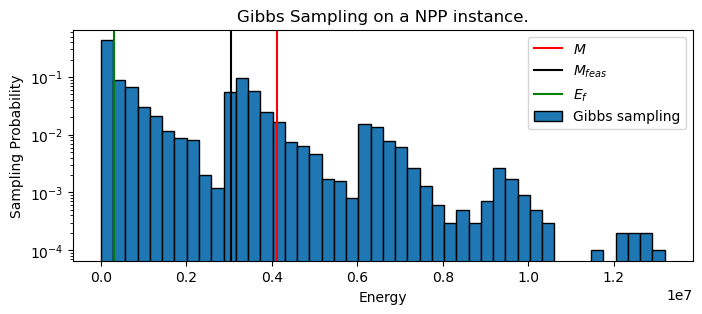

In [6]:
### Test M method (create problem, apply technique, simulate Gibbs sampling and plot)
from myalgo import M_method_opt, M_method_feas

# 1. set problem 
problem_type = "NPP"
if problem_type == "NPP":
    N, P = 9, 2
    n_bits = N*P
    size = (N, P)
    print(f"NPP problem, size:  N = {N}, P = {P}")
elif problem_type == "TSP":
    N_cities = 4
    n_bits = N_cities**2
    size = N_cities
    print(f"TSP problem, size:  N_citites = {N_cities}")
vseed = 42
circle_flag = False # for TSP: os True, the instances are generated on a circle like Fujitsu did, else, the cities are randomly placed

# 2. set parameters: temperature, min_probabilty, max_energy and vioaltion_peaks
beta = 1e-6
peak_max = 4
min_pfeas = 0.5 # eta
E_f = 3e5

# 3. apply method to find penalty M
E_LB = 0
M, eta_guaran = M_method_opt(size, problem_type, vseed, "seed", beta, peak_max, min_pfeas, E_f, E_LB, circle_flag)
#M_badtail, eta_guaran_badtail = M_method_badtail(size, problem_type, vseed, "seed", beta, peak_max, min_pfeas, E_f, E_LB, circle_flag)
M_feas, eta_guaran_feas = M_method_feas(size, problem_type, vseed, "seed", beta, peak_max, min_pfeas, E_LB, circle_flag)

M, M_feas = M.astype(float), M_feas.astype(float)

# 4. build QUBO with M and sample from it with Gibbs
n_sample = 10_000
M_QUBO = M_feas
if problem_type == "NPP":
    Q, const = get_QUBO_NPP(N, P, M_QUBO, vseed)
    Q_pen, const_pen = get_QUBO_NPP(N, P, M_QUBO, vseed, objective=False)
elif problem_type == "TSP":
    Q, const = get_QUBO_TSP(N_cities, M_QUBO, vseed, circle_flag = False)
    Q_pen, const_pen = get_QUBO_TSP(N_cities, M_QUBO, vseed, objective=False)

Es, states = perf_GibbsSampler(beta, Q, const, n_bits, n_sample)
# measure sampling quality (feasibility and optimality)
feas_prob, opt_prob = count_feasibility_optimality(states, Q_pen, const_pen, Es, E_f)
print(f"\nSampling prob. feasible = {feas_prob}  >= Sampling prob. feasible and energy in [0 , E_f={E_f}] = {opt_prob}")

### M_l1 (beta)
Q_obj, const_obj = get_QUBO_NPP(N, P, 0, vseed, penalization = False)
M_L1_hot = L1_norm_hot(Q_obj, const_obj, N*P, 1/beta, max_prob_inf = min_pfeas)
print(f"M_l1 in hot environment for this instance: {np.format_float_scientific(M_L1_hot, 2)}")

# 5. plot and check prob_feas for Gibbs and bit-swap
# get histogram data
bins ="auto"
counts, x_bins = np.histogram(Es.flatten(), bins = bins)
density = counts / counts.sum() # normalize to get a probability
x_pos = (x_bins[1:] + x_bins[:-1])/2
bin_width = x_bins[1]-x_bins[0]
mask = density > 0 # filter out empty bins
density, x_pos = density[mask], x_pos[mask]
# plot
fig = plt.figure(figsize=(8, 3))
ax = fig.add_subplot(111)
ax.bar(x_pos, density, width = bin_width, edgecolor='k', linewidth=1, label ="Gibbs sampling")
ax.set_ylabel("Sampling Probability")
ax.set_xlabel("Energy")
#ax.set_xlim(0, 2.2*M)
plt.title(f"Gibbs Sampling, {problem_type} instance, bits = {n_bits}.")
plt.title(f"Gibbs Sampling on a {problem_type} instance.")
ax.axvline(M, color = "r", label = r"$M$")
#ax.axvline(M_badtail, color = "r", linestyle = "--", label = r"$M_{badtail}$")
ax.axvline(M_feas, color = "k", label = r"$M_{feas}$")
#ax.axvline(M_L1_hot, color = "k")
ax.set_yscale("log")
ax.axvline(E_f, color = "g", label = r"$E_f$")
#ax.set_xscale("log")
ax.legend(fontsize = 10, loc='best')
plt.show()

#fig.savefig("Gibbs")

#### $M$ and $\eta$ guaranteed dependence on $E_f$ and 

In [16]:
### Test M method at varying E_f. Also, minimum probability guaranteed as a fct of E_f
#from myalgo import M_method

# 1. set problem 
problem_type = "NPP"
if problem_type == "NPP":
    N, P = 9, 2
    size = (N, P)
    print(f"NPP problem, size:  N = {N}, P = {P}")
elif problem_type == "TSP":
    N_cities = 4
    size = N_cities
    print(f"TSP problem, size:  N_citites = {N_cities}")
vseed = 42
circle_flag = False # for TSP: os True, the instances are generated on a circle like Fujitsu did, else, the cities are randomly placed


# 2. set parameters: temperature, min_probabilty, max_energy and vioaltion_peaks
beta = 1e-5
peak_max = 4
min_pfeas = 0.5 # eta
E_LB = 0


Efs = np.logspace(3, 6, 40)
Ms_toplot, eta_guarantes = np.ndarray((len(Efs))), np.ndarray((len(Efs)))

# 3. apply method to find penalty M
for i, E_f in enumerate(Efs):
    Ms_toplot[i], eta_guarantes[i] = M_method_opt(size, problem_type, vseed, "seed", beta, peak_max, min_pfeas, E_f, E_LB, circle_flag)

valid = np.isclose(eta_guarantes, min_pfeas) 

NPP problem, size:  N = 9, P = 2
With tolerance 0.5, poly root doesn't exist. Feasibility tolerance decreased to 0.05035779516140064
For this instance, sampling temperature = 1.e+05 and required probability in [0, E_f = 1000.0] at least 0.05, the chosen M is 5.5e+05 (last violation peak used is 4)
With tolerance 0.5, poly root doesn't exist. Feasibility tolerance decreased to 0.08217353291185689
For this instance, sampling temperature = 1.e+05 and required probability in [0, E_f = 1193.776641714437] at least 0.082, the chosen M is 6.04e+05 (last violation peak used is 4)
With tolerance 0.5, poly root doesn't exist. Feasibility tolerance decreased to 0.07760038483563365
For this instance, sampling temperature = 1.e+05 and required probability in [0, E_f = 1425.1026703029977] at least 0.078, the chosen M is 5.94e+05 (last violation peak used is 4)
With tolerance 0.5, poly root doesn't exist. Feasibility tolerance decreased to 0.12248405490151265
For this instance, sampling temperature = 

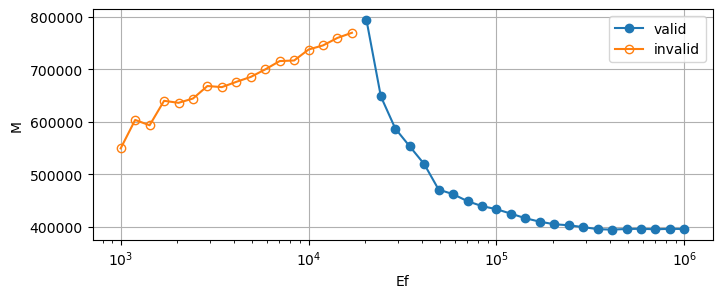

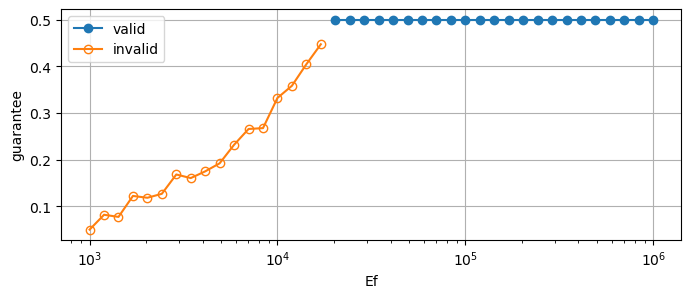

In [17]:
fig = plt.figure(figsize=(8, 3))
ax = fig.add_subplot(111)
ax.plot(Efs[valid], Ms_toplot[valid], "-o", label = "valid")
ax.plot(Efs[np.logical_not(valid)], Ms_toplot[np.logical_not(valid)], "-o", fillstyle='none', label = "invalid")
ax.set_ylabel("M")
ax.set_xlabel("Ef")
ax.set_xscale("log")
#ax.set_yscale("log")
ax.legend(fontsize = 10, loc='best')
ax.grid()
plt.show()

fig = plt.figure(figsize=(8, 3))
ax = fig.add_subplot(111)
ax.plot(Efs[valid], eta_guarantes[valid], "-o", label = "valid")
ax.plot(Efs[np.logical_not(valid)], eta_guarantes[np.logical_not(valid)], "-o", fillstyle='none', label = "invalid")
ax.set_ylabel("guarantee")
ax.set_xlabel("Ef")
ax.set_xscale("log")
#ax.set_yscale("log")
ax.legend(fontsize = 10, loc='best')
ax.grid()
plt.show()

#### $\eta$ required vs $\eta$ effective

In [ ]:
# 1. set problem 
problem_type = "NPP"
P = 2
vseed = 42


# 2. set parameters
beta = 1e-5
peak_max = 4
min_pfeas = 0.5 # eta
E_LB = 0


Ns = np.array([7, 8, 9])
betas = np.array([1e-5, 5e-6, 2e-6, 1e-6,])
etas_required = np.array([.35, .4, .45, .5, .55, .6, .65])
E_f = 1e6

etas_guaranteed = np.ndarray((len(Ns), len(betas), len(etas_required)))
etas_effective = np.ndarray((len(Ns), len(betas), len(etas_required)))

for N_idx, N in enumerate(tqdm.tqdm(Ns)):
    n_bits = N*P
    size = (N, P)

    for beta_idx, beta in enumerate(betas):

        for eta_idx, eta_req in enumerate(etas_required):
            # run method with parameters and collect eta guaranteed
            M, etas_guaranteed[N_idx, beta_idx, eta_idx] = M_method_opt(size, problem_type, vseed, "seed", beta, peak_max, eta_req, E_f, E_LB)
            M = M.astype(float)

            # run gibbs sampling and
            n_sample = 1000
            Q, const = get_QUBO_NPP(N, P, M, vseed)
            Q_pen, const_pen = get_QUBO_NPP(N, P, M, vseed, objective=False)
            Es, states = perf_GibbsSampler(beta, Q, const, n_bits, n_sample)

            # collect eta effective
            feas_prob, opt_prob = count_feasibility_optimality(states, Q_pen, const_pen, Es, E_f)
            etas_effective[N_idx, beta_idx, eta_idx] = opt_prob


  0%|          | 0/3 [00:00<?, ?it/s]

For this instance, sampling temperature = 1.e+05 and required probability in [0, E_f = 1000000.0] at least 0.35, the chosen M is 300378.32260131836 (last violation peak used is 4)
For this instance, sampling temperature = 1.e+05 and required probability in [0, E_f = 1000000.0] at least 0.4, the chosen M is 316868.3052062988 (last violation peak used is 4)
For this instance, sampling temperature = 1.e+05 and required probability in [0, E_f = 1000000.0] at least 0.45, the chosen M is 336368.0839538574 (last violation peak used is 4)
For this instance, sampling temperature = 1.e+05 and required probability in [0, E_f = 1000000.0] at least 0.5, the chosen M is 352570.0569152832 (last violation peak used is 4)
For this instance, sampling temperature = 1.e+05 and required probability in [0, E_f = 1000000.0] at least 0.55, the chosen M is 373213.2911682129 (last violation peak used is 4)
For this instance, sampling temperature = 1.e+05 and required probability in [0, E_f = 1000000.0] at least

 33%|███▎      | 1/3 [00:12<00:24, 12.03s/it]

For this instance, sampling temperature = 1.e+06 and required probability in [0, E_f = 1000000.0] at least 0.65, the chosen M is 3749146.491289139 (last violation peak used is 4)
For this instance, sampling temperature = 1.e+05 and required probability in [0, E_f = 1000000.0] at least 0.35, the chosen M is 311164.37911987305 (last violation peak used is 4)
For this instance, sampling temperature = 1.e+05 and required probability in [0, E_f = 1000000.0] at least 0.4, the chosen M is 331079.95986938477 (last violation peak used is 4)
For this instance, sampling temperature = 1.e+05 and required probability in [0, E_f = 1000000.0] at least 0.45, the chosen M is 350408.07723999023 (last violation peak used is 4)
For this instance, sampling temperature = 1.e+05 and required probability in [0, E_f = 1000000.0] at least 0.5, the chosen M is 367785.9306335449 (last violation peak used is 4)
For this instance, sampling temperature = 1.e+05 and required probability in [0, E_f = 1000000.0] at lea

 67%|██████▋   | 2/3 [00:29<00:15, 15.06s/it]

For this instance, sampling temperature = 1.e+05 and required probability in [0, E_f = 1000000.0] at least 0.35, the chosen M is 341179.37088012695 (last violation peak used is 4)
For this instance, sampling temperature = 1.e+05 and required probability in [0, E_f = 1000000.0] at least 0.4, the chosen M is 358941.55502319336 (last violation peak used is 4)
For this instance, sampling temperature = 1.e+05 and required probability in [0, E_f = 1000000.0] at least 0.45, the chosen M is 377419.94857788086 (last violation peak used is 4)
For this instance, sampling temperature = 1.e+05 and required probability in [0, E_f = 1000000.0] at least 0.5, the chosen M is 395100.1167297363 (last violation peak used is 4)
For this instance, sampling temperature = 1.e+05 and required probability in [0, E_f = 1000000.0] at least 0.55, the chosen M is 416190.62423706055 (last violation peak used is 4)
For this instance, sampling temperature = 1.e+05 and required probability in [0, E_f = 1000000.0] at le

100%|██████████| 3/3 [01:09<00:00, 23.03s/it]


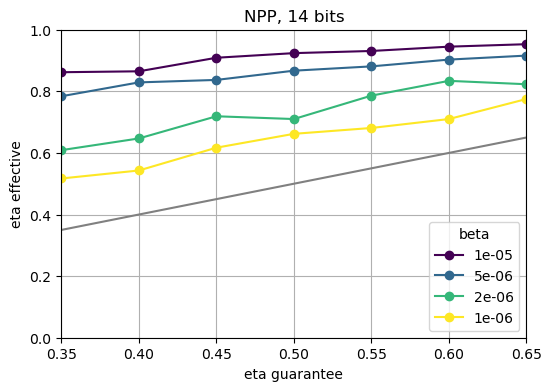

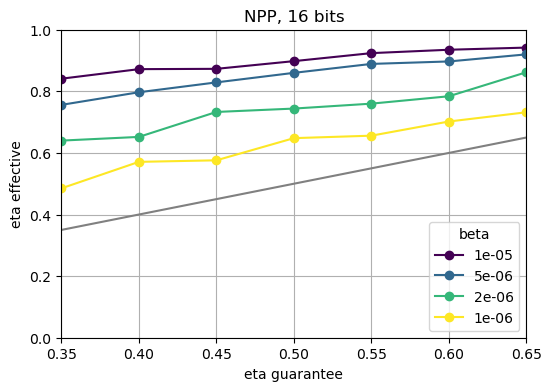

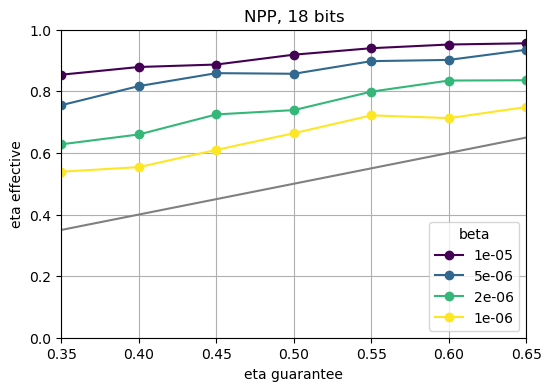

In [ ]:
# plot

from matplotlib.colors import ListedColormap
colormap = plt.cm.viridis.reversed()
discr_colors = ListedColormap(colormap(np.linspace(0, 1, len(betas)))).reversed()

for N_idx, N in enumerate(Ns):
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111)
    for beta_idx, beta in enumerate(betas):
        req_satisf = np.isclose(etas_guaranteed[N_idx, beta_idx], etas_required) # mask to differentiate where the guarantee is the required one (True), or the guarantee had to be decreased (False)
        ax.plot(etas_required[req_satisf], etas_effective[N_idx, beta_idx][req_satisf], "-o", color = discr_colors.colors[beta_idx], label = f"{beta}")
        ax.plot(etas_guaranteed[N_idx, beta_idx][np.logical_not(req_satisf)], etas_effective[N_idx, beta_idx][np.logical_not(req_satisf)], "-o", color = discr_colors.colors[beta_idx], fillstyle='none')
    ax.set_ylabel("eta effective")
    ax.set_xlabel("eta guarantee")
    ax.set_title(f"NPP, {N*P} bits")
    ax.plot(etas_required, etas_required, color = "gray")
    ax.legend(fontsize = 10, loc='best', title = "beta")
    ax.set_xlim(np.min(etas_required), np.max(etas_required))
    ax.set_ylim(0, 1)
    ax.grid()
    plt.show()

### $\eta$ required vs $\eta$ effective  ---  feasibility only strategy

In [11]:
# 1. set problem 
problem_type = "NPP"
P = 2
vseed = 42


# 2. set parameters
beta = 1e-5
peak_max = 4
min_pfeas = 0.5 # eta
E_LB = 0


Ns = np.array([7, 8, 9])
betas = np.array([1e-5, 5e-6, 2e-6, 1e-6,])
etas_required = np.array([.35, .4, .45, .5, .55, .6, .65])

betas = np.array([1e-5, 1e-6, 1e-7])
etas_required = np.array([.1, .3, .5, .7, .9])

etas_guaranteed = np.ndarray((len(Ns), len(betas), len(etas_required)))
etas_effective = np.ndarray((len(Ns), len(betas), len(etas_required)))

for N_idx, N in enumerate(tqdm.tqdm(Ns)):
    n_bits = N*P
    size = (N, P)

    for beta_idx, beta in enumerate(betas):

        for eta_idx, eta_req in enumerate(etas_required):
            # run method with parameters and collect eta guaranteed
            M, etas_guaranteed[N_idx, beta_idx, eta_idx] = M_method_feas(size, problem_type, vseed, "seed", beta, peak_max, eta_req, E_LB)
            M = M.astype(float)

            # run gibbs sampling and
            n_sample = 1000
            Q, const = get_QUBO_NPP(N, P, M, vseed)
            Q_pen, const_pen = get_QUBO_NPP(N, P, M, vseed, objective=False)
            Es, states = perf_GibbsSampler(beta, Q, const, n_bits, n_sample)

            # collect eta effective
            feas_prob, opt_prob = count_feasibility_optimality(states, Q_pen, const_pen, Es, E_f = np.max(Es))
            etas_effective[N_idx, beta_idx, eta_idx] = feas_prob

  0%|          | 0/3 [00:00<?, ?it/s]

For this instance, sampling temperature = 1.e+05 and required feasible probability in at least 0.1, the chosen M is 1.77e+05 (last violation peak used is 4)
For this instance, sampling temperature = 1.e+05 and required feasible probability in at least 0.3, the chosen M is 2.80e+05 (last violation peak used is 4)
For this instance, sampling temperature = 1.e+05 and required feasible probability in at least 0.5, the chosen M is 3.53e+05 (last violation peak used is 4)
For this instance, sampling temperature = 1.e+05 and required feasible probability in at least 0.7, the chosen M is 4.35e+05 (last violation peak used is 4)
For this instance, sampling temperature = 1.e+05 and required feasible probability in at least 0.9, the chosen M is 5.67e+05 (last violation peak used is 4)
For this instance, sampling temperature = 1.e+06 and required feasible probability in at least 0.1, the chosen M is 1.25e+06 (last violation peak used is 4)
For this instance, sampling temperature = 1.e+06 and requi

 33%|███▎      | 1/3 [00:04<00:09,  4.92s/it]

For this instance, sampling temperature = 1.e+07 and required feasible probability in at least 0.9, the chosen M is 4.30e+07 (last violation peak used is 4)
For this instance, sampling temperature = 1.e+05 and required feasible probability in at least 0.1, the chosen M is 1.93e+05 (last violation peak used is 4)
For this instance, sampling temperature = 1.e+05 and required feasible probability in at least 0.3, the chosen M is 2.93e+05 (last violation peak used is 4)
For this instance, sampling temperature = 1.e+05 and required feasible probability in at least 0.5, the chosen M is 3.66e+05 (last violation peak used is 4)
For this instance, sampling temperature = 1.e+05 and required feasible probability in at least 0.7, the chosen M is 4.5e+05 (last violation peak used is 4)
For this instance, sampling temperature = 1.e+05 and required feasible probability in at least 0.9, the chosen M is 5.80e+05 (last violation peak used is 4)
For this instance, sampling temperature = 1.e+06 and requir

 67%|██████▋   | 2/3 [00:12<00:06,  6.42s/it]

For this instance, sampling temperature = 1.e+05 and required feasible probability in at least 0.1, the chosen M is 2.16e+05 (last violation peak used is 4)
For this instance, sampling temperature = 1.e+05 and required feasible probability in at least 0.3, the chosen M is 3.19e+05 (last violation peak used is 4)
For this instance, sampling temperature = 1.e+05 and required feasible probability in at least 0.5, the chosen M is 3.94e+05 (last violation peak used is 4)
For this instance, sampling temperature = 1.e+05 and required feasible probability in at least 0.7, the chosen M is 4.75e+05 (last violation peak used is 4)
For this instance, sampling temperature = 1.e+05 and required feasible probability in at least 0.9, the chosen M is 6.11e+05 (last violation peak used is 4)
For this instance, sampling temperature = 1.e+06 and required feasible probability in at least 0.1, the chosen M is 1.54e+06 (last violation peak used is 4)
For this instance, sampling temperature = 1.e+06 and requi

100%|██████████| 3/3 [00:32<00:00, 10.73s/it]


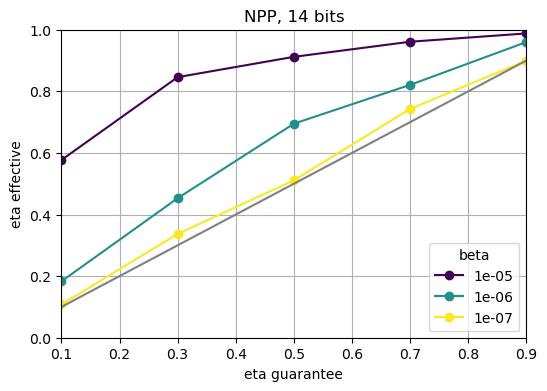

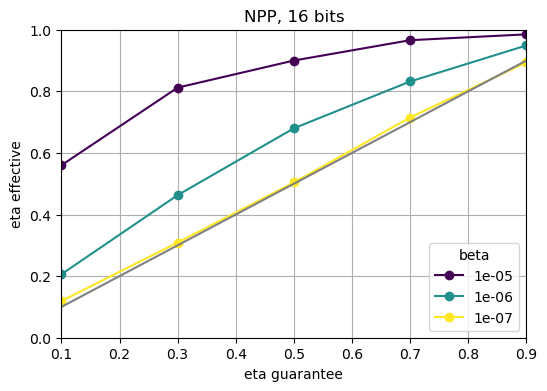

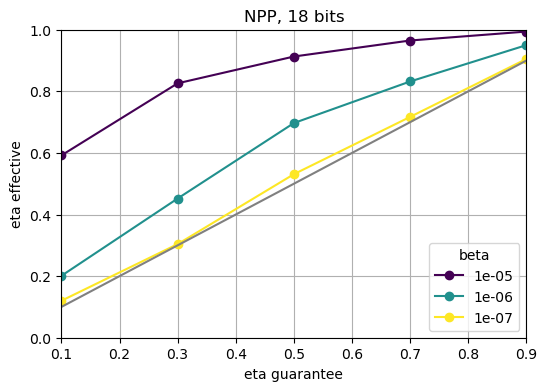

In [12]:
# plot

from matplotlib.colors import ListedColormap
colormap = plt.cm.viridis.reversed()
discr_colors = ListedColormap(colormap(np.linspace(0, 1, len(betas)))).reversed()

for N_idx, N in enumerate(Ns):
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111)
    for beta_idx, beta in enumerate(betas):
        req_satisf = np.isclose(etas_guaranteed[N_idx, beta_idx], etas_required) # mask to differentiate where the guarantee is the required one (True), or the guarantee had to be decreased (False)
        ax.plot(etas_required[req_satisf], etas_effective[N_idx, beta_idx][req_satisf], "-o", color = discr_colors.colors[beta_idx], label = f"{beta}")
        ax.plot(etas_guaranteed[N_idx, beta_idx][np.logical_not(req_satisf)], etas_effective[N_idx, beta_idx][np.logical_not(req_satisf)], "-o", color = discr_colors.colors[beta_idx], fillstyle='none')
    ax.set_ylabel("eta effective")
    ax.set_xlabel("eta guarantee")
    ax.set_title(f"NPP, {N*P} bits")
    ax.plot(etas_required, etas_required, color = "gray")
    ax.legend(fontsize = 10, loc='best', title = "beta")
    ax.set_xlim(np.min(etas_required), np.max(etas_required))
    ax.set_ylim(0, 1)
    ax.grid()
    plt.show()

#### Varying max_peak

In [ ]:
# ### Test M method (create problem, apply technique, simulate Gibbs sampling and plot)

# # 1. set problem 
# problem_type = "TSP"
# if problem_type == "NPP":
#     N, P = 9, 2
#     n_bits = N*P
#     size = (N, P)
#     print(f"NPP problem, size:  N = {N}, P = {P}")
# elif problem_type == "TSP":
#     N_cities = 4
#     n_bits = N_cities**2
#     size = N_cities
#     print(f"TSP problem, size:  N_citites = {N_cities}")
# vseed = 45


# # 2. set parameters: temperature, min_probabilty, max_energy and vioaltion_peaks
# beta = 1e-5
# min_pfeas = 0.5 # eta
# E_f = 1e7


# # 3. apply method to find penalty M
# E_LB = 0
# max_peaks_tested = np.arange(1, 5)
# feas_probs, opt_probs = np.ndarray((len(max_peaks_tested))), np.ndarray((len(max_peaks_tested)))
# for idx_peak, peak_max in enumerate(max_peaks_tested):
#     M = M_method_opt(size, problem_type, vseed, beta, peak_max, min_pfeas, E_f, E_LB)

#     # 4. build QUBO with M and sample from it with Gibbs
#     n_sample = 100_000
#     if problem_type == "NPP":
#         Q, const = get_QUBO_NPP(N, P, M, vseed)
#         Q_pen, const_pen = get_QUBO_NPP(N, P, M, vseed, objective=False)
#     elif problem_type == "TSP":
#         Q, const = get_QUBO_TSP(N_cities, M, vseed, circle_flag = False)
#         Q_pen, const_pen = get_QUBO_TSP(N_cities, M, vseed, objective=False)

#     Es, states = perf_GibbsSampler(beta, Q, const, n_bits, n_sample)
#     # measure sampling quality (feasibility and optimality)
#     feas_probs[idx_peak], opt_probs[idx_peak] = count_feasibility_optimality(states, Q_pen, const_pen, Es, E_f)
#     print(f"Feasib. sampling prob is {feas_probs[idx_peak]}  >=  Feasible points ratio in [0 , E_f={E_f}] is {opt_probs[idx_peak]}")


# # 5. plot
# # plot
# fig = plt.figure(figsize=(8, 5))
# ax = fig.add_subplot(111)
# ax.plot(max_peaks_tested, feas_probs, "o", color = "C0", label = "feasible prob")
# ax.plot(max_peaks_tested, opt_probs, "o", color = "C1", label = "[feasible and E<Ef] prob")
# ax.set_ylabel("prob feaasible")
# ax.set_xlabel("max peak")
# plt.title(f"feasibility sampling probability, {problem_type} instance, bits = {n_bits}.\n beta: {beta}")
# ax.axhline(min_pfeas, color = "k", label = "min prob required")
# #ax.set_yscale("log")
# ax.legend(fontsize = 10, loc='best')
# plt.grid()
# plt.show()


#### testing the single bounds

In [ ]:
### Cumulative tests (testing Pf lower bound)

def cumulative_NPP(E_f, beta, N, P, seed, n_samples = 10_000):

    eners = RandomSampler_Feasible_NPP(N, P, seed, n_samples)

    # cumul-unique
    crude_cumul = np.sum(eners <= E_f)/len(eners)
    # cumul-divided
    n_chunks = 100
    E_LB = 0
    delta = (E_f - E_LB) / n_chunks
    cum_exp = np.sum([ np.exp(- beta * (E_LB + (j+1)*delta) ) * np.sum( np.logical_and(eners >= E_LB + j*delta, eners <= E_LB + (j+1)*delta) )/ len(eners) for j in np.arange(n_chunks) ])

    for n_chunks in [1, 10, 1e2, 1e3, 1e4]:
        delta = (E_f - E_LB) / n_chunks
        cum_exp_tests = np.sum([ np.exp(- beta * (E_LB + (j+1)*delta) ) * np.sum( np.logical_and(eners >= E_LB + j*delta, eners <= E_LB + (j+1)*delta) )/ len(eners) for j in np.arange(n_chunks) ])
        print(f"With {int(n_chunks)} chunks the integral is {cum_exp_tests}")
    
    # compute comulative by fitting
    bins = 100
    counts, x_bins = np.histogram(eners.flatten(), bins = bins)
    density = counts / counts.sum() # normalize to get a probability
    x_pos = (x_bins[1:] + x_bins[:-1])/2
    bin_width = x_bins[1]-x_bins[0]
    mask = density > 0 # filter out empty bins
    density, x_pos = density[mask], x_pos[mask]

    fig = plt.figure(figsize=(8, 3))
    ax = fig.add_subplot(111)
    ax.bar(x_pos, density, width = bin_width, edgecolor='k', linewidth=1, label ="Random sampling")
    ax.axvline(E_f, color = "r")
    plt.show()

    print(f"Crude_cum_exp= {crude_cumul*np.exp(-beta*E_f)}\nCum_exp_divided= {cum_exp}")
    #cum_divided_test = np.sum([ np.sum( np.logical_and(eners >= E_LB + j*delta, eners <= E_LB + (j+1)*delta) )/ len(eners) for j in np.arange(n_chunks) ])
    #print(f"Crude cumul= {crude_cumul}\nCum__divided= {cum_divided_test}")
    
    # XS = np.linspace(x_pos[0], x_pos[-1], 1000)
    # f = lambda x, D, beta, normal : gamma.pdf(x, (D+1)/2, loc = 0, scale = 1/beta) * bin_width * normal
    # ax.plot(XS, f(XS, *[.5, 2e-7, 1]), color = "C1")
    # coef, coef_var = sp.optimize.curve_fit(f, x_pos, density, p0 = [.5, 2e-7, 1])    
    # ax.plot(XS, f(XS, *coef), color = "C3", label = f"MB fit, D={np.round(coef[0], 2)}")
    return crude_cumul


N, P = 10, 4
E_f = 3e5
beta = 1e-3
seed = 45
cumul = cumulative_NPP(E_f, beta, N, P, seed)


## M test on DA-NPP dichotomic search

#### Da data

In [6]:
## import data
directory = "DA/data_dichotomic_NPP/1/"
l_measures = 70 # it is the number of M-trials with dichotomic search [ i.e. the max of len( list( summary['measurements'].keys() ) )]
n_instances = 128

data_M, data_temp, data_rate, data_par = -np.ones((n_instances, l_measures)), -np.ones((n_instances, l_measures, 2)), -np.ones((n_instances, l_measures)), np.ndarray((n_instances, 2), dtype = int) # data_par is N, P at final index, in this order
data_values = {}


import os, json
files = np.sort([file for file in os.listdir(directory) if file[-4:] == "json"])


max_len_Ms = 0
for inst_idx, file in enumerate(files):

    filename =  directory+file
    if not os.path.isfile(filename):
        print(f"{filename} doesn't exist")
        continue

    with open(filename, 'r') as fp:
        summary = json.load(fp)
        data_par[inst_idx] = summary['N'], summary['P']
        Ms = list(summary['measurements'].keys())
        if len(Ms) > max_len_Ms:
            max_len_Ms = len(Ms)
        assert len(Ms) <= l_measures
        data_M[inst_idx, :len(Ms)] = Ms
        data_values[inst_idx] = summary['values']

        for M_idx, M in enumerate(Ms):
            data_temp[inst_idx, M_idx] = summary['measurements'][str(M)]['temperature_start'], summary['measurements'][str(M)]['temperature_end']
            data_rate[inst_idx, M_idx] = summary['measurements'][str(M)]['rate']
print(f'Read data --> Done')


data_M, data_temp, data_rate = data_M[:, :max_len_Ms], data_temp[:, :max_len_Ms], data_rate[:, :max_len_Ms]
l_measures = max_len_Ms


Read data --> Done


In [7]:
#idx, el_nearest = nearest_to(array, element)

def simulate_bisection(probability, inst_idx):
    M_history, rate_history, temp_i_history, temp_f_history = [], [], [], []
    M_low, M_high = 0, 2e9
    while True:
        M = int(.5 * (M_low + M_high))
        M_idx, M = nearest_to(data_M[inst_idx], M)
        rate_M = data_rate[inst_idx, M_idx]
        M_history.append(M)
        rate_history.append(rate_M)
        temp_i_history.append(data_temp[inst_idx, M_idx, 0])
        temp_f_history.append(data_temp[inst_idx, M_idx, 1])
        if rate_M > probability:
            M_high = M
        else:
            M_low = M
        if M_high - M_low < 100:
                break
    return np.array(M_history), np.array(rate_history), np.swapaxes( np.vstack((temp_i_history, temp_f_history)) , 0, 1)


prob = .5 # .25, .5 or .75
inst_idx = 0
M_history, rate_history,temps_history = simulate_bisection(prob, inst_idx)

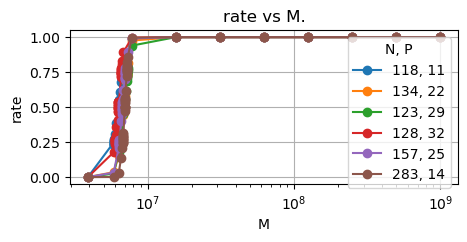

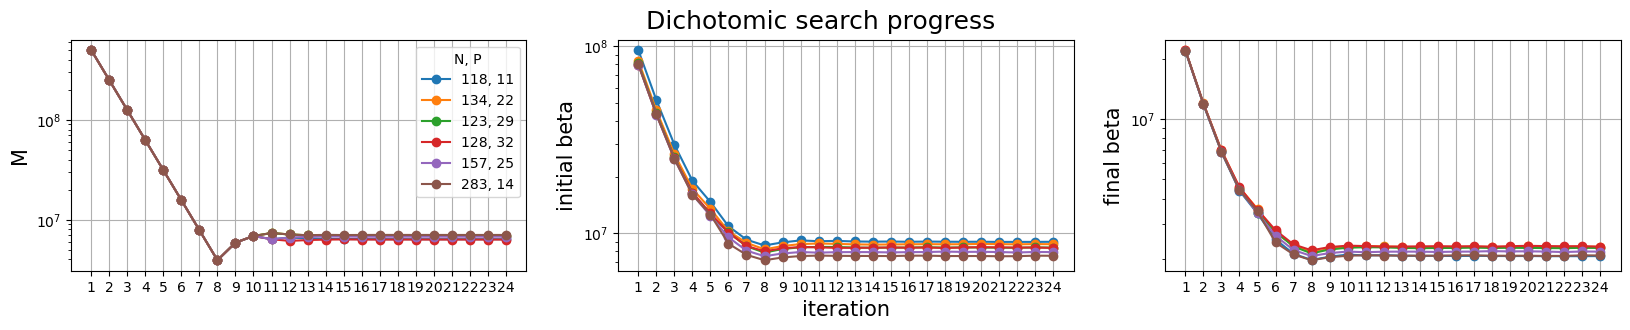

In [8]:
instances = [0, 1, 2, 3, 7, 8]


fig = plt.figure(figsize=(5, 2))
ax = fig.add_subplot(111)
for inst_idx in instances:
    mask = data_M[inst_idx] > 0
    ax.plot(data_M[inst_idx, mask], data_rate[inst_idx, mask], "-o", label = f"{data_par[inst_idx, 0]}, {data_par[inst_idx, 1]}")
ax.set_ylabel("rate")
ax.set_xlabel("M")
ax.set_title(f"rate vs M.")
ax.set_xscale("log")
ax.legend(fontsize = 10, loc='best', title = "N, P")
plt.grid()
plt.show()

prob_target = .5
jump_first = 1
fig = plt.figure(figsize=(20,3))
plt.suptitle("Dichotomic search progress", fontsize = 18)
ax1, ax2, ax3 = fig.add_subplot(131), fig.add_subplot(132), fig.add_subplot(133)
for inst_idx in instances:
    M_history, rate_history, temps_history = simulate_bisection(prob_target, inst_idx)
    ax1.plot(np.arange(jump_first, len(M_history)), M_history[jump_first:], "-o", label = f"{data_par[inst_idx, 0]}, {data_par[inst_idx, 1]}")
    ax2.plot(np.arange(jump_first, len(M_history)), temps_history[jump_first:, 0], "-o")
    ax3.plot(np.arange(jump_first, len(M_history)), temps_history[jump_first:, 1], "-o")
ax2.set_xlabel("iteration", fontsize = 15)
ax1.set_ylabel("M", fontsize = 15)
ax2.set_ylabel("initial beta", fontsize = 15)
ax3.set_ylabel("final beta", fontsize = 15)
for ax in [ax1, ax2, ax3]:
    ax.set_yscale("log")
    ax.set_xticks(np.arange(jump_first, len(M_history)))
    ax.grid()
ax1.legend(fontsize = 10, loc='best', title = "N, P")
plt.show()

#### apply M

In [9]:
# apply M method to DA instances
from myalgo import M_method_opt, M_method_feas

# set parameters: temperature, min_probabilty, max_energy and violation_peaks
problem_type = "NPP"

E_LB = 0
peak_max = 4
min_pfeas = .5 # eta
E_f = 1e9 #? should be high since DA data refer to feasible only (need to study M(Ef) behavior to understand it better)

for inst_idx in range(2):
    valid_temps = data_temp[inst_idx, :, 1] > 1
    beta = 1/np.median(data_temp[inst_idx, valid_temps, 1])
    N, P = data_par[inst_idx]
    size = (N, P)
    numbers_NPP = data_values[inst_idx]

    M, eta_guarantee = M_method_opt(size, problem_type, numbers_NPP, "numbers", beta, peak_max, min_pfeas, E_f, E_LB)


For this instance, sampling temperature = 2.074e+06 and required probability in [0, E_f = 1000000000.0] at least 0.5, the chosen M is 1.73e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.302e+06 and required probability in [0, E_f = 1000000000.0] at least 0.5, the chosen M is 2.20e+07 (last violation peak used is 4)


For this instance, sampling temperature = 2.074e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 1.76e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.074e+06 and required feasible probability in at least 0.5, the chosen M is 1.72e+07 (last violation peak used is 4)


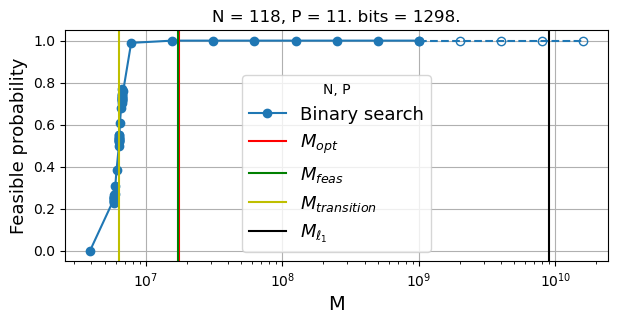

In [23]:
# set parameters: temperature, min_probabilty, max_energy and vioaltion_peaks
problem_type = "NPP"
E_LB = 0
peak_max = 4
min_pfeas = .5 # eta
E_f = 1e10

for inst_idx in np.arange(1):
    N, P = data_par[inst_idx]
    size = (N, P)
    numbers_NPP = data_values[inst_idx]

    valid_temps = data_temp[inst_idx, :, 1] > 1
    beta_avg = 1/np.median(data_temp[inst_idx, valid_temps, 1])
    M, eta_guarantee = M_method_opt(size, problem_type, numbers_NPP, "numbers", beta_avg, peak_max, min_pfeas, E_f, E_LB)
    M_feas, eta_guarantee = M_method_feas(size, problem_type, numbers_NPP, "numbers", beta_avg, peak_max, min_pfeas, E_LB)
    #M_bad, eta_guarantee = M_method_badtail(size, problem_type, numbers_NPP, "numbers", beta_avg, peak_max, min_pfeas, E_f, E_LB)

    M_trans_idx, _ = nearest_to(data_rate[inst_idx], min_pfeas)
    M_trans = data_M[inst_idx, M_trans_idx]
    # beta_trans = 1/data_temp[inst_idx, M_trans_idx, 1]
    # M_UB_trans = M_method_DA(size, problem_type, numbers_NPP, beta_trans, peak_max, min_pfeas, E_f, E_LB

    # L1 norm estimate of M
    Q_obj, const_obj = build_obj_NPP(numbers_NPP, N, P)
    M_L1 = L1_norm(Q_obj, const_obj)
    M_L1_hot = L1_norm_hot(Q_obj, const_obj, N*P, 1/beta_avg, max_prob_inf = min_pfeas)

    fig = plt.figure(figsize=(7, 3))
    ax = fig.add_subplot(111)
    mask = data_M[inst_idx] > 0
    #ax.plot(data_M[inst_idx, mask], data_rate[inst_idx, mask], "-o", label = f"{data_par[inst_idx, 0]}, {data_par[inst_idx, 1]}")
    ax.plot(data_M[inst_idx, mask], data_rate[inst_idx, mask], "-o", label = "Binary search")
    ax.axvline(M, color = "r", label = r"$M_{opt}$")
    ax.axvline(M_feas, color = "g", label = r"$M_{feas}$")
    #ax.axvline(M_bad, linestyle = "--", color = "g", label = r"$M^*_{badtail}$")
    ax.axvline(M_trans, color = "y", label = r"$M_{transition}$")
    ax.axvline(M_L1_hot, color = "k", label = r"$M_{\ell_1}$")
    
    fake_points = np.array([1, 2, 4, 8, 16])*1e9
    ax.plot(fake_points, np.ones((len(fake_points))), "--o", color = "C0", fillstyle='none')
    
    ax.set_ylabel("Feasible probability", fontsize = 13)
    ax.set_xlabel("M", fontsize = 14)
    ax.set_title(f"N = {N}, P = {P}. bits = {N*P}.")
    ax.set_xscale("log")
    ax.legend(fontsize = 13, loc='best', title = "N, P")
    plt.grid()
    plt.show()

#fig.savefig("NPP_dichotomic")

### ratio M / M_trans

  0%|          | 0/128 [00:00<?, ?it/s]

For this instance, sampling temperature = 2.074e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 1.76e+07 (last violation peak used is 4)


  1%|          | 1/128 [00:01<02:34,  1.21s/it]

For this instance, sampling temperature = 2.074e+06 and required feasible probability in at least 0.5, the chosen M is 1.72e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.302e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.24e+07 (last violation peak used is 4)


  2%|▏         | 2/128 [00:02<03:09,  1.50s/it]

For this instance, sampling temperature = 2.302e+06 and required feasible probability in at least 0.5, the chosen M is 2.2e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.273e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.23e+07 (last violation peak used is 4)


  2%|▏         | 3/128 [00:04<03:31,  1.70s/it]

For this instance, sampling temperature = 2.273e+06 and required feasible probability in at least 0.5, the chosen M is 2.19e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.317e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.34e+07 (last violation peak used is 4)


  3%|▎         | 4/128 [00:06<03:45,  1.82s/it]

For this instance, sampling temperature = 2.317e+06 and required feasible probability in at least 0.5, the chosen M is 2.29e+07 (last violation peak used is 4)
For this instance, sampling temperature = 1.916e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.15e+07 (last violation peak used is 4)


  4%|▍         | 5/128 [00:08<03:30,  1.71s/it]

For this instance, sampling temperature = 1.916e+06 and required feasible probability in at least 0.5, the chosen M is 2.11e+07 (last violation peak used is 4)
For this instance, sampling temperature = 1.899e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 1.86e+07 (last violation peak used is 4)


  5%|▍         | 6/128 [00:09<02:58,  1.47s/it]

For this instance, sampling temperature = 1.899e+06 and required feasible probability in at least 0.5, the chosen M is 1.80e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.035e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.03e+07 (last violation peak used is 4)


  5%|▌         | 7/128 [00:10<02:48,  1.39s/it]

For this instance, sampling temperature = 2.035e+06 and required feasible probability in at least 0.5, the chosen M is 1.98e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.179e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.27e+07 (last violation peak used is 4)


  6%|▋         | 8/128 [00:12<03:01,  1.51s/it]

For this instance, sampling temperature = 2.179e+06 and required feasible probability in at least 0.5, the chosen M is 2.22e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.078e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.44e+07 (last violation peak used is 4)


  7%|▋         | 9/128 [00:13<02:53,  1.46s/it]

For this instance, sampling temperature = 2.078e+06 and required feasible probability in at least 0.5, the chosen M is 2.38e+07 (last violation peak used is 4)
For this instance, sampling temperature = 1.963e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.29e+07 (last violation peak used is 4)


  8%|▊         | 10/128 [00:14<02:41,  1.36s/it]

For this instance, sampling temperature = 1.963e+06 and required feasible probability in at least 0.5, the chosen M is 2.22e+07 (last violation peak used is 4)
For this instance, sampling temperature = 1.965e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.19e+07 (last violation peak used is 4)


  9%|▊         | 11/128 [00:15<02:29,  1.28s/it]

For this instance, sampling temperature = 1.965e+06 and required feasible probability in at least 0.5, the chosen M is 2.16e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.253e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.27e+07 (last violation peak used is 4)


  9%|▉         | 12/128 [00:17<02:48,  1.45s/it]

For this instance, sampling temperature = 2.253e+06 and required feasible probability in at least 0.5, the chosen M is 2.22e+07 (last violation peak used is 4)
For this instance, sampling temperature = 1.932e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.36e+07 (last violation peak used is 4)


 10%|█         | 13/128 [00:18<02:36,  1.36s/it]

For this instance, sampling temperature = 1.932e+06 and required feasible probability in at least 0.5, the chosen M is 2.32e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.127e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 1.62e+07 (last violation peak used is 4)


 11%|█         | 14/128 [00:19<02:19,  1.22s/it]

For this instance, sampling temperature = 2.127e+06 and required feasible probability in at least 0.5, the chosen M is 1.58e+07 (last violation peak used is 4)
For this instance, sampling temperature = 1.951e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 1.79e+07 (last violation peak used is 4)


 12%|█▏        | 15/128 [00:20<02:11,  1.16s/it]

For this instance, sampling temperature = 1.951e+06 and required feasible probability in at least 0.5, the chosen M is 1.75e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.247e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.24e+07 (last violation peak used is 4)


 12%|█▎        | 16/128 [00:22<02:36,  1.40s/it]

For this instance, sampling temperature = 2.247e+06 and required feasible probability in at least 0.5, the chosen M is 2.19e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.147e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 1.87e+07 (last violation peak used is 4)


 13%|█▎        | 17/128 [00:24<02:30,  1.35s/it]

For this instance, sampling temperature = 2.147e+06 and required feasible probability in at least 0.5, the chosen M is 1.83e+07 (last violation peak used is 4)
For this instance, sampling temperature = 1.821e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 1.37e+07 (last violation peak used is 4)


 14%|█▍        | 18/128 [00:24<02:14,  1.22s/it]

For this instance, sampling temperature = 1.821e+06 and required feasible probability in at least 0.5, the chosen M is 1.33e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.267e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.05e+07 (last violation peak used is 4)


 15%|█▍        | 19/128 [00:26<02:12,  1.21s/it]

For this instance, sampling temperature = 2.267e+06 and required feasible probability in at least 0.5, the chosen M is 2.01e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.144e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.05e+07 (last violation peak used is 4)


 16%|█▌        | 20/128 [00:27<02:25,  1.35s/it]

For this instance, sampling temperature = 2.144e+06 and required feasible probability in at least 0.5, the chosen M is 2.00e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.025e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 1.98e+07 (last violation peak used is 4)


 16%|█▋        | 21/128 [00:28<02:13,  1.25s/it]

For this instance, sampling temperature = 2.025e+06 and required feasible probability in at least 0.5, the chosen M is 1.94e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.181e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 1.83e+07 (last violation peak used is 4)


 17%|█▋        | 22/128 [00:29<02:08,  1.21s/it]

For this instance, sampling temperature = 2.181e+06 and required feasible probability in at least 0.5, the chosen M is 1.79e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.050e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.47e+07 (last violation peak used is 4)


 18%|█▊        | 23/128 [00:31<02:09,  1.23s/it]

For this instance, sampling temperature = 2.050e+06 and required feasible probability in at least 0.5, the chosen M is 2.43e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.117e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.14e+07 (last violation peak used is 4)


 19%|█▉        | 24/128 [00:33<02:34,  1.48s/it]

For this instance, sampling temperature = 2.117e+06 and required feasible probability in at least 0.5, the chosen M is 2.09e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.273e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.30e+07 (last violation peak used is 4)


 20%|█▉        | 25/128 [00:35<02:53,  1.69s/it]

For this instance, sampling temperature = 2.273e+06 and required feasible probability in at least 0.5, the chosen M is 2.26e+07 (last violation peak used is 4)
For this instance, sampling temperature = 1.964e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 1.73e+07 (last violation peak used is 4)


 20%|██        | 26/128 [00:36<02:31,  1.49s/it]

For this instance, sampling temperature = 1.964e+06 and required feasible probability in at least 0.5, the chosen M is 1.68e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.328e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.46e+07 (last violation peak used is 4)


 21%|██        | 27/128 [00:38<02:33,  1.52s/it]

For this instance, sampling temperature = 2.328e+06 and required feasible probability in at least 0.5, the chosen M is 2.41e+07 (last violation peak used is 4)
For this instance, sampling temperature = 1.976e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.22e+07 (last violation peak used is 4)


 22%|██▏       | 28/128 [00:39<02:30,  1.50s/it]

For this instance, sampling temperature = 1.976e+06 and required feasible probability in at least 0.5, the chosen M is 2.18e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.143e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.40e+07 (last violation peak used is 4)


 23%|██▎       | 29/128 [00:41<02:28,  1.50s/it]

For this instance, sampling temperature = 2.143e+06 and required feasible probability in at least 0.5, the chosen M is 2.36e+07 (last violation peak used is 4)
For this instance, sampling temperature = 1.987e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.38e+07 (last violation peak used is 4)


 23%|██▎       | 30/128 [00:42<02:18,  1.41s/it]

For this instance, sampling temperature = 1.987e+06 and required feasible probability in at least 0.5, the chosen M is 2.33e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.336e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.38e+07 (last violation peak used is 4)


 24%|██▍       | 31/128 [00:44<02:37,  1.62s/it]

For this instance, sampling temperature = 2.336e+06 and required feasible probability in at least 0.5, the chosen M is 2.33e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.183e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.4e+07 (last violation peak used is 4)


 25%|██▌       | 32/128 [00:45<02:29,  1.55s/it]

For this instance, sampling temperature = 2.183e+06 and required feasible probability in at least 0.5, the chosen M is 2.34e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.227e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.26e+07 (last violation peak used is 4)


 26%|██▌       | 33/128 [00:47<02:45,  1.74s/it]

For this instance, sampling temperature = 2.227e+06 and required feasible probability in at least 0.5, the chosen M is 2.21e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.266e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 1.83e+07 (last violation peak used is 4)


 27%|██▋       | 34/128 [00:49<02:36,  1.67s/it]

For this instance, sampling temperature = 2.266e+06 and required feasible probability in at least 0.5, the chosen M is 1.79e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.088e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 1.78e+07 (last violation peak used is 4)


 27%|██▋       | 35/128 [00:50<02:27,  1.59s/it]

For this instance, sampling temperature = 2.088e+06 and required feasible probability in at least 0.5, the chosen M is 1.73e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.264e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.1e+07 (last violation peak used is 4)


 28%|██▊       | 36/128 [00:52<02:33,  1.67s/it]

For this instance, sampling temperature = 2.264e+06 and required feasible probability in at least 0.5, the chosen M is 2.05e+07 (last violation peak used is 4)
For this instance, sampling temperature = 1.957e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 1.68e+07 (last violation peak used is 4)


 29%|██▉       | 37/128 [00:53<02:13,  1.47s/it]

For this instance, sampling temperature = 1.957e+06 and required feasible probability in at least 0.5, the chosen M is 1.64e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.382e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.52e+07 (last violation peak used is 4)


 30%|██▉       | 38/128 [00:55<02:16,  1.52s/it]

For this instance, sampling temperature = 2.382e+06 and required feasible probability in at least 0.5, the chosen M is 2.47e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.219e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.23e+07 (last violation peak used is 4)


 30%|███       | 39/128 [00:57<02:27,  1.65s/it]

For this instance, sampling temperature = 2.219e+06 and required feasible probability in at least 0.5, the chosen M is 2.18e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.117e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.10e+07 (last violation peak used is 4)


 31%|███▏      | 40/128 [00:58<02:22,  1.62s/it]

For this instance, sampling temperature = 2.117e+06 and required feasible probability in at least 0.5, the chosen M is 2.06e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.091e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.37e+07 (last violation peak used is 4)


 32%|███▏      | 41/128 [01:00<02:15,  1.56s/it]

For this instance, sampling temperature = 2.091e+06 and required feasible probability in at least 0.5, the chosen M is 2.32e+07 (last violation peak used is 4)
For this instance, sampling temperature = 1.984e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 1.92e+07 (last violation peak used is 4)


 33%|███▎      | 42/128 [01:01<02:05,  1.45s/it]

For this instance, sampling temperature = 1.984e+06 and required feasible probability in at least 0.5, the chosen M is 1.88e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.353e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.14e+07 (last violation peak used is 4)


 34%|███▎      | 43/128 [01:03<02:13,  1.57s/it]

For this instance, sampling temperature = 2.353e+06 and required feasible probability in at least 0.5, the chosen M is 2.09e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.060e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.17e+07 (last violation peak used is 4)


 34%|███▍      | 44/128 [01:05<02:18,  1.64s/it]

For this instance, sampling temperature = 2.060e+06 and required feasible probability in at least 0.5, the chosen M is 2.12e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.254e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.27e+07 (last violation peak used is 4)


 35%|███▌      | 45/128 [01:07<02:28,  1.79s/it]

For this instance, sampling temperature = 2.254e+06 and required feasible probability in at least 0.5, the chosen M is 2.22e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.058e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 1.38e+07 (last violation peak used is 4)


 36%|███▌      | 46/128 [01:08<02:11,  1.60s/it]

For this instance, sampling temperature = 2.058e+06 and required feasible probability in at least 0.5, the chosen M is 1.34e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.232e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.32e+07 (last violation peak used is 4)


 37%|███▋      | 47/128 [01:10<02:10,  1.61s/it]

For this instance, sampling temperature = 2.232e+06 and required feasible probability in at least 0.5, the chosen M is 2.27e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.124e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.11e+07 (last violation peak used is 4)


 38%|███▊      | 48/128 [01:11<02:03,  1.55s/it]

For this instance, sampling temperature = 2.124e+06 and required feasible probability in at least 0.5, the chosen M is 2.07e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.249e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.02e+07 (last violation peak used is 4)


 38%|███▊      | 49/128 [01:13<02:03,  1.57s/it]

For this instance, sampling temperature = 2.249e+06 and required feasible probability in at least 0.5, the chosen M is 1.97e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.180e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.51e+07 (last violation peak used is 4)


 39%|███▉      | 50/128 [01:14<01:58,  1.52s/it]

For this instance, sampling temperature = 2.180e+06 and required feasible probability in at least 0.5, the chosen M is 2.47e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.276e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.34e+07 (last violation peak used is 4)


 40%|███▉      | 51/128 [01:16<02:02,  1.59s/it]

For this instance, sampling temperature = 2.276e+06 and required feasible probability in at least 0.5, the chosen M is 2.29e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.183e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.35e+07 (last violation peak used is 4)


 41%|████      | 52/128 [01:17<01:57,  1.54s/it]

For this instance, sampling temperature = 2.183e+06 and required feasible probability in at least 0.5, the chosen M is 2.31e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.263e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.46e+07 (last violation peak used is 4)


 41%|████▏     | 53/128 [01:19<01:59,  1.60s/it]

For this instance, sampling temperature = 2.263e+06 and required feasible probability in at least 0.5, the chosen M is 2.41e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.114e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 1.89e+07 (last violation peak used is 4)


 42%|████▏     | 54/128 [01:20<01:49,  1.48s/it]

For this instance, sampling temperature = 2.114e+06 and required feasible probability in at least 0.5, the chosen M is 1.85e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.168e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.22e+07 (last violation peak used is 4)


 43%|████▎     | 55/128 [01:22<01:54,  1.57s/it]

For this instance, sampling temperature = 2.168e+06 and required feasible probability in at least 0.5, the chosen M is 2.17e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.106e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 1.83e+07 (last violation peak used is 4)


 44%|████▍     | 56/128 [01:23<01:52,  1.56s/it]

For this instance, sampling temperature = 2.106e+06 and required feasible probability in at least 0.5, the chosen M is 1.79e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.104e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 1.91e+07 (last violation peak used is 4)


 45%|████▍     | 57/128 [01:25<01:42,  1.44s/it]

For this instance, sampling temperature = 2.104e+06 and required feasible probability in at least 0.5, the chosen M is 1.87e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.102e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 1.94e+07 (last violation peak used is 4)


 45%|████▌     | 58/128 [01:26<01:41,  1.46s/it]

For this instance, sampling temperature = 2.102e+06 and required feasible probability in at least 0.5, the chosen M is 1.89e+07 (last violation peak used is 4)
For this instance, sampling temperature = 1.932e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.08e+07 (last violation peak used is 4)


 46%|████▌     | 59/128 [01:27<01:31,  1.33s/it]

For this instance, sampling temperature = 1.932e+06 and required feasible probability in at least 0.5, the chosen M is 2.03e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.163e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.51e+07 (last violation peak used is 4)


 47%|████▋     | 60/128 [01:29<01:32,  1.36s/it]

For this instance, sampling temperature = 2.163e+06 and required feasible probability in at least 0.5, the chosen M is 2.47e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.311e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.3e+07 (last violation peak used is 4)


 48%|████▊     | 61/128 [01:30<01:42,  1.54s/it]

For this instance, sampling temperature = 2.311e+06 and required feasible probability in at least 0.5, the chosen M is 2.25e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.159e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.42e+07 (last violation peak used is 4)


 48%|████▊     | 62/128 [01:32<01:41,  1.53s/it]

For this instance, sampling temperature = 2.159e+06 and required feasible probability in at least 0.5, the chosen M is 2.37e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.003e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.04e+07 (last violation peak used is 4)


 49%|████▉     | 63/128 [01:33<01:35,  1.48s/it]

For this instance, sampling temperature = 2.003e+06 and required feasible probability in at least 0.5, the chosen M is 1.99e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.122e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.03e+07 (last violation peak used is 4)


 50%|█████     | 64/128 [01:35<01:45,  1.64s/it]

For this instance, sampling temperature = 2.122e+06 and required feasible probability in at least 0.5, the chosen M is 1.99e+07 (last violation peak used is 4)
For this instance, sampling temperature = 1.956e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.03e+07 (last violation peak used is 4)


 51%|█████     | 65/128 [01:37<01:42,  1.63s/it]

For this instance, sampling temperature = 1.956e+06 and required feasible probability in at least 0.5, the chosen M is 1.98e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.296e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.19e+07 (last violation peak used is 4)


 52%|█████▏    | 66/128 [01:39<01:45,  1.71s/it]

For this instance, sampling temperature = 2.296e+06 and required feasible probability in at least 0.5, the chosen M is 2.14e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.049e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.48e+07 (last violation peak used is 4)


 52%|█████▏    | 67/128 [01:40<01:37,  1.60s/it]

For this instance, sampling temperature = 2.049e+06 and required feasible probability in at least 0.5, the chosen M is 2.45e+07 (last violation peak used is 4)


 53%|█████▎    | 68/128 [01:42<01:33,  1.55s/it]

For this instance, sampling temperature = 2.128e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 1.74e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.128e+06 and required feasible probability in at least 0.5, the chosen M is 1.70e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.211e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.09e+07 (last violation peak used is 4)


 54%|█████▍    | 69/128 [01:43<01:32,  1.57s/it]

For this instance, sampling temperature = 2.211e+06 and required feasible probability in at least 0.5, the chosen M is 2.04e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.129e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 1.87e+07 (last violation peak used is 4)


 55%|█████▍    | 70/128 [01:44<01:24,  1.46s/it]

For this instance, sampling temperature = 2.129e+06 and required feasible probability in at least 0.5, the chosen M is 1.83e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.223e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 1.8e+07 (last violation peak used is 4)


 55%|█████▌    | 71/128 [01:46<01:20,  1.41s/it]

For this instance, sampling temperature = 2.223e+06 and required feasible probability in at least 0.5, the chosen M is 1.75e+07 (last violation peak used is 4)
For this instance, sampling temperature = 1.946e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 1.22e+07 (last violation peak used is 4)


 56%|█████▋    | 72/128 [01:47<01:08,  1.23s/it]

For this instance, sampling temperature = 1.946e+06 and required feasible probability in at least 0.5, the chosen M is 1.17e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.260e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.07e+07 (last violation peak used is 4)


 57%|█████▋    | 73/128 [01:48<01:12,  1.32s/it]

For this instance, sampling temperature = 2.260e+06 and required feasible probability in at least 0.5, the chosen M is 2.02e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.002e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.06e+07 (last violation peak used is 4)


 58%|█████▊    | 74/128 [01:49<01:10,  1.30s/it]

For this instance, sampling temperature = 2.002e+06 and required feasible probability in at least 0.5, the chosen M is 2.01e+07 (last violation peak used is 4)


 59%|█████▊    | 75/128 [01:51<01:19,  1.50s/it]

For this instance, sampling temperature = 2.221e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.24e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.221e+06 and required feasible probability in at least 0.5, the chosen M is 2.2e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.333e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.56e+07 (last violation peak used is 4)


 59%|█████▉    | 76/128 [01:53<01:19,  1.52s/it]

For this instance, sampling temperature = 2.333e+06 and required feasible probability in at least 0.5, the chosen M is 2.51e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.136e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.51e+07 (last violation peak used is 4)


 60%|██████    | 77/128 [01:54<01:14,  1.45s/it]

For this instance, sampling temperature = 2.136e+06 and required feasible probability in at least 0.5, the chosen M is 2.45e+07 (last violation peak used is 4)
For this instance, sampling temperature = 1.917e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.11e+07 (last violation peak used is 4)


 61%|██████    | 78/128 [01:55<01:07,  1.36s/it]

For this instance, sampling temperature = 1.917e+06 and required feasible probability in at least 0.5, the chosen M is 2.09e+07 (last violation peak used is 4)
For this instance, sampling temperature = 1.973e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 1.81e+07 (last violation peak used is 4)


 62%|██████▏   | 79/128 [01:57<01:11,  1.46s/it]

For this instance, sampling temperature = 1.973e+06 and required feasible probability in at least 0.5, the chosen M is 1.77e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.403e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.52e+07 (last violation peak used is 4)


 62%|██████▎   | 80/128 [01:59<01:14,  1.56s/it]

For this instance, sampling temperature = 2.403e+06 and required feasible probability in at least 0.5, the chosen M is 2.47e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.095e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.36e+07 (last violation peak used is 4)


 63%|██████▎   | 81/128 [02:00<01:14,  1.58s/it]

For this instance, sampling temperature = 2.095e+06 and required feasible probability in at least 0.5, the chosen M is 2.31e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.093e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.13e+07 (last violation peak used is 4)


 64%|██████▍   | 82/128 [02:02<01:08,  1.50s/it]

For this instance, sampling temperature = 2.093e+06 and required feasible probability in at least 0.5, the chosen M is 2.09e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.079e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.06e+07 (last violation peak used is 4)


 65%|██████▍   | 83/128 [02:03<01:00,  1.35s/it]

For this instance, sampling temperature = 2.079e+06 and required feasible probability in at least 0.5, the chosen M is 2.01e+07 (last violation peak used is 4)
For this instance, sampling temperature = 1.960e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.30e+07 (last violation peak used is 4)


 66%|██████▌   | 84/128 [02:04<00:56,  1.29s/it]

For this instance, sampling temperature = 1.960e+06 and required feasible probability in at least 0.5, the chosen M is 2.24e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.064e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 1.60e+07 (last violation peak used is 4)


 66%|██████▋   | 85/128 [02:05<00:54,  1.26s/it]

For this instance, sampling temperature = 2.064e+06 and required feasible probability in at least 0.5, the chosen M is 1.56e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.153e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 1.97e+07 (last violation peak used is 4)


 67%|██████▋   | 86/128 [02:07<00:56,  1.33s/it]

For this instance, sampling temperature = 2.153e+06 and required feasible probability in at least 0.5, the chosen M is 1.93e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.013e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.33e+07 (last violation peak used is 4)


 68%|██████▊   | 87/128 [02:08<00:52,  1.27s/it]

For this instance, sampling temperature = 2.013e+06 and required feasible probability in at least 0.5, the chosen M is 2.28e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.053e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.08e+07 (last violation peak used is 4)


 69%|██████▉   | 88/128 [02:10<01:01,  1.53s/it]

For this instance, sampling temperature = 2.053e+06 and required feasible probability in at least 0.5, the chosen M is 2.03e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.137e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.06e+07 (last violation peak used is 4)


 70%|██████▉   | 89/128 [02:11<01:00,  1.56s/it]

For this instance, sampling temperature = 2.137e+06 and required feasible probability in at least 0.5, the chosen M is 2.01e+07 (last violation peak used is 4)
For this instance, sampling temperature = 1.938e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.21e+07 (last violation peak used is 4)


 70%|███████   | 90/128 [02:13<00:54,  1.42s/it]

For this instance, sampling temperature = 1.938e+06 and required feasible probability in at least 0.5, the chosen M is 2.15e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.250e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.4e+07 (last violation peak used is 4)


 71%|███████   | 91/128 [02:14<00:55,  1.49s/it]

For this instance, sampling temperature = 2.250e+06 and required feasible probability in at least 0.5, the chosen M is 2.35e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.265e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.35e+07 (last violation peak used is 4)


 72%|███████▏  | 92/128 [02:16<00:53,  1.49s/it]

For this instance, sampling temperature = 2.265e+06 and required feasible probability in at least 0.5, the chosen M is 2.31e+07 (last violation peak used is 4)
For this instance, sampling temperature = 1.967e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.18e+07 (last violation peak used is 4)


 73%|███████▎  | 93/128 [02:17<00:48,  1.39s/it]

For this instance, sampling temperature = 1.967e+06 and required feasible probability in at least 0.5, the chosen M is 2.15e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.208e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.18e+07 (last violation peak used is 4)


 73%|███████▎  | 94/128 [02:19<00:49,  1.46s/it]

For this instance, sampling temperature = 2.208e+06 and required feasible probability in at least 0.5, the chosen M is 2.13e+07 (last violation peak used is 4)
For this instance, sampling temperature = 1.882e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 1.18e+07 (last violation peak used is 4)


 74%|███████▍  | 95/128 [02:19<00:42,  1.29s/it]

For this instance, sampling temperature = 1.882e+06 and required feasible probability in at least 0.5, the chosen M is 1.14e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.169e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.34e+07 (last violation peak used is 4)


 75%|███████▌  | 96/128 [02:21<00:42,  1.32s/it]

For this instance, sampling temperature = 2.169e+06 and required feasible probability in at least 0.5, the chosen M is 2.30e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.125e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.21e+07 (last violation peak used is 4)


 76%|███████▌  | 97/128 [02:22<00:40,  1.31s/it]

For this instance, sampling temperature = 2.125e+06 and required feasible probability in at least 0.5, the chosen M is 2.16e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.261e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.29e+07 (last violation peak used is 4)


 77%|███████▋  | 98/128 [02:24<00:46,  1.54s/it]

For this instance, sampling temperature = 2.261e+06 and required feasible probability in at least 0.5, the chosen M is 2.24e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.100e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.36e+07 (last violation peak used is 4)


 77%|███████▋  | 99/128 [02:26<00:44,  1.53s/it]

For this instance, sampling temperature = 2.100e+06 and required feasible probability in at least 0.5, the chosen M is 2.31e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.192e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 1.89e+07 (last violation peak used is 4)


 78%|███████▊  | 100/128 [02:27<00:42,  1.51s/it]

For this instance, sampling temperature = 2.192e+06 and required feasible probability in at least 0.5, the chosen M is 1.84e+07 (last violation peak used is 4)
For this instance, sampling temperature = 1.902e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 1.76e+07 (last violation peak used is 4)


 79%|███████▉  | 101/128 [02:28<00:36,  1.36s/it]

For this instance, sampling temperature = 1.902e+06 and required feasible probability in at least 0.5, the chosen M is 1.72e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.461e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.39e+07 (last violation peak used is 4)


 80%|███████▉  | 102/128 [02:30<00:39,  1.50s/it]

For this instance, sampling temperature = 2.461e+06 and required feasible probability in at least 0.5, the chosen M is 2.34e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.302e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.48e+07 (last violation peak used is 4)


 80%|████████  | 103/128 [02:32<00:38,  1.54s/it]

For this instance, sampling temperature = 2.302e+06 and required feasible probability in at least 0.5, the chosen M is 2.43e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.124e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.47e+07 (last violation peak used is 4)


 81%|████████▏ | 104/128 [02:33<00:34,  1.45s/it]

For this instance, sampling temperature = 2.124e+06 and required feasible probability in at least 0.5, the chosen M is 2.42e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.278e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.26e+07 (last violation peak used is 4)


 82%|████████▏ | 105/128 [02:35<00:35,  1.56s/it]

For this instance, sampling temperature = 2.278e+06 and required feasible probability in at least 0.5, the chosen M is 2.21e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.351e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.37e+07 (last violation peak used is 4)


 83%|████████▎ | 106/128 [02:37<00:37,  1.72s/it]

For this instance, sampling temperature = 2.351e+06 and required feasible probability in at least 0.5, the chosen M is 2.33e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.237e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.26e+07 (last violation peak used is 4)


 84%|████████▎ | 107/128 [02:38<00:34,  1.66s/it]

For this instance, sampling temperature = 2.237e+06 and required feasible probability in at least 0.5, the chosen M is 2.21e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.115e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 1.99e+07 (last violation peak used is 4)


 84%|████████▍ | 108/128 [02:40<00:33,  1.66s/it]

For this instance, sampling temperature = 2.115e+06 and required feasible probability in at least 0.5, the chosen M is 1.94e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.126e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.12e+07 (last violation peak used is 4)


 85%|████████▌ | 109/128 [02:41<00:28,  1.49s/it]

For this instance, sampling temperature = 2.126e+06 and required feasible probability in at least 0.5, the chosen M is 2.08e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.016e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.22e+07 (last violation peak used is 4)


 86%|████████▌ | 110/128 [02:42<00:24,  1.38s/it]

For this instance, sampling temperature = 2.016e+06 and required feasible probability in at least 0.5, the chosen M is 2.18e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.325e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.4e+07 (last violation peak used is 4)


 87%|████████▋ | 111/128 [02:44<00:24,  1.47s/it]

For this instance, sampling temperature = 2.325e+06 and required feasible probability in at least 0.5, the chosen M is 2.35e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.116e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.33e+07 (last violation peak used is 4)


 88%|████████▊ | 112/128 [02:45<00:21,  1.35s/it]

For this instance, sampling temperature = 2.116e+06 and required feasible probability in at least 0.5, the chosen M is 2.27e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.17e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.33e+07 (last violation peak used is 4)


 88%|████████▊ | 113/128 [02:47<00:21,  1.44s/it]

For this instance, sampling temperature = 2.17e+06 and required feasible probability in at least 0.5, the chosen M is 2.29e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.081e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.36e+07 (last violation peak used is 4)


 89%|████████▉ | 114/128 [02:48<00:19,  1.41s/it]

For this instance, sampling temperature = 2.081e+06 and required feasible probability in at least 0.5, the chosen M is 2.31e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.166e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 1.98e+07 (last violation peak used is 4)


 90%|████████▉ | 115/128 [02:50<00:20,  1.55s/it]

For this instance, sampling temperature = 2.166e+06 and required feasible probability in at least 0.5, the chosen M is 1.93e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.055e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.02e+07 (last violation peak used is 4)


 91%|█████████ | 116/128 [02:51<00:19,  1.59s/it]

For this instance, sampling temperature = 2.055e+06 and required feasible probability in at least 0.5, the chosen M is 1.97e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.284e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.27e+07 (last violation peak used is 4)


 91%|█████████▏| 117/128 [02:53<00:18,  1.69s/it]

For this instance, sampling temperature = 2.284e+06 and required feasible probability in at least 0.5, the chosen M is 2.23e+07 (last violation peak used is 4)
For this instance, sampling temperature = 1.971e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.06e+07 (last violation peak used is 4)


 92%|█████████▏| 118/128 [02:55<00:15,  1.55s/it]

For this instance, sampling temperature = 1.971e+06 and required feasible probability in at least 0.5, the chosen M is 2.01e+07 (last violation peak used is 4)
For this instance, sampling temperature = 1.998e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 1.88e+07 (last violation peak used is 4)


 93%|█████████▎| 119/128 [02:56<00:14,  1.56s/it]

For this instance, sampling temperature = 1.998e+06 and required feasible probability in at least 0.5, the chosen M is 1.84e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.215e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.12e+07 (last violation peak used is 4)


 94%|█████████▍| 120/128 [02:58<00:12,  1.59s/it]

For this instance, sampling temperature = 2.215e+06 and required feasible probability in at least 0.5, the chosen M is 2.07e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.225e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 1.87e+07 (last violation peak used is 4)


 95%|█████████▍| 121/128 [02:59<00:10,  1.57s/it]

For this instance, sampling temperature = 2.225e+06 and required feasible probability in at least 0.5, the chosen M is 1.83e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.049e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 1.72e+07 (last violation peak used is 4)


 95%|█████████▌| 122/128 [03:00<00:08,  1.39s/it]

For this instance, sampling temperature = 2.049e+06 and required feasible probability in at least 0.5, the chosen M is 1.67e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.054e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 1.81e+07 (last violation peak used is 4)


 96%|█████████▌| 123/128 [03:01<00:06,  1.31s/it]

For this instance, sampling temperature = 2.054e+06 and required feasible probability in at least 0.5, the chosen M is 1.76e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.133e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.12e+07 (last violation peak used is 4)


 97%|█████████▋| 124/128 [03:04<00:06,  1.57s/it]

For this instance, sampling temperature = 2.133e+06 and required feasible probability in at least 0.5, the chosen M is 2.07e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.028e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 1.86e+07 (last violation peak used is 4)


 98%|█████████▊| 125/128 [03:05<00:04,  1.66s/it]

For this instance, sampling temperature = 2.028e+06 and required feasible probability in at least 0.5, the chosen M is 1.82e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.263e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.31e+07 (last violation peak used is 4)


 98%|█████████▊| 126/128 [03:08<00:03,  1.79s/it]

For this instance, sampling temperature = 2.263e+06 and required feasible probability in at least 0.5, the chosen M is 2.27e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.172e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.3e+07 (last violation peak used is 4)


 99%|█████████▉| 127/128 [03:09<00:01,  1.80s/it]

For this instance, sampling temperature = 2.172e+06 and required feasible probability in at least 0.5, the chosen M is 2.25e+07 (last violation peak used is 4)
For this instance, sampling temperature = 2.260e+06 and required probability in [0, E_f = 10000000000.0] at least 0.5, the chosen M is 2.25e+07 (last violation peak used is 4)


100%|██████████| 128/128 [03:12<00:00,  1.50s/it]

For this instance, sampling temperature = 2.260e+06 and required feasible probability in at least 0.5, the chosen M is 2.2e+07 (last violation peak used is 4)


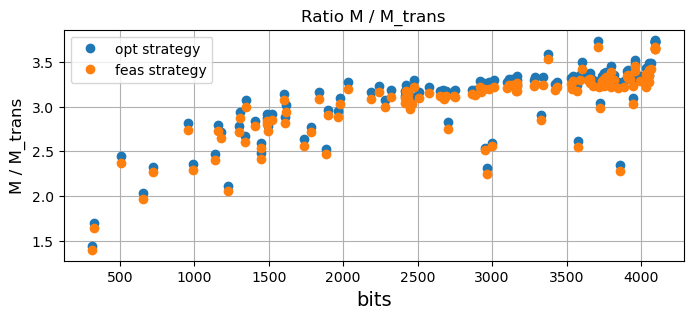

In [28]:
# ratio M / M_transition  ---  comparing the optimality strategy, with a high E_f to capture hopefully the whole feasible subspace, and the feasibility strategy
# (sorted according to number of bits) #TODO maybe according to N or P can be meaningful

ratios_M, ratios_M_feas, bits_axes = np.ndarray((n_instances)), np.ndarray((n_instances)), np.ndarray((n_instances))

problem_type = "NPP"
E_f = 1e10
min_pfeas = 0.5 # eta
E_LB = 0
peak_max = 4

for inst_idx in tqdm.tqdm(range(n_instances)):
    N, P = data_par[inst_idx]
    size = (N, P)
    bits_axes[inst_idx] = N*P
    ### compute transition M
    M_idx_trans, rate_trans = nearest_to(data_rate[inst_idx], .5)
    M_trans = data_M[inst_idx, M_idx_trans]
    ### compute M from recipe
    numbers_NPP = data_values[inst_idx]
    valid_temps = data_temp[inst_idx, :, 1] > 1
    beta_avg = 1/np.median(data_temp[inst_idx, valid_temps, 1])
    M, eta_guarantee = M_method_opt(size, problem_type, numbers_NPP, "numbers", beta_avg, peak_max, min_pfeas, E_f, E_LB)
    M_feas, eta_guarantee = M_method_feas(size, problem_type, numbers_NPP, "numbers", beta_avg, peak_max, min_pfeas, E_LB)
    # beta_single = 1 / np.mean(data_temp[N_idx, M_idx_trans, inst_idx, :, 1])
    # M_estimated_single = M_method_opt(size, problem_type, numbers_NPP, "numbers", beta_single, peak_max, min_pfeas, E_f, E_LB)

    ratios_M[inst_idx] = M / M_trans
    ratios_M_feas[inst_idx] = M_feas / M_trans
    
idx_sorted = np.argsort(bits_axes)

fig = plt.figure(figsize=(8, 3))
ax = fig.add_subplot(1, 1, 1)
ax.set_title(f"Ratio M / M_trans")                   
ax.plot(bits_axes[idx_sorted], ratios_M[idx_sorted],"o", label = "opt strategy")
ax.plot(bits_axes[idx_sorted], ratios_M_feas[idx_sorted],"o", label = "feas strategy")
ax.set_ylabel("M / M_trans", fontsize=12)
ax.set_xlabel("bits",fontsize=14)
ax.legend(fontsize = 10, loc='best')
#plt.yscale('log')
plt.grid()
